# Final Project - Analysis of the Evolution of Alliances and Polarization in the French National Assembly through MPs’ Votes and Speeches (14th–17th Legislatures)

02805 Social Graphs and Interactions

## GROUP 44
- Rémi Berthelot (s254144)
- Antoine Bois-Belioz (s252363)
- Pierre Hollebèque (s254136)

This notebook first contains all useful functions. They are then used in the respective sections for the sake of readability.

# Utils

In [ ]:
import json, os, sys, math, requests, re, random, io
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import networkx as nx
from collections import Counter
import matplotlib.lines as mlines
from itertools import combinations
import math
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
import matplotlib.cm as cm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Data Loading

The preprocessed data is imported using GIST.

In [ ]:
gistlinks = {
    "communities":{
        14:"https://gist.github.com/reberthelot/31508afb2c26f3245249af8b62d201c1/raw/7f3be8fd7686aff1877233f91422aa214c59f853/communities_14.json",
        15:"https://gist.github.com/reberthelot/31508afb2c26f3245249af8b62d201c1/raw/7f3be8fd7686aff1877233f91422aa214c59f853/communities_15.json",
        16:"https://gist.github.com/reberthelot/31508afb2c26f3245249af8b62d201c1/raw/7f3be8fd7686aff1877233f91422aa214c59f853/communities_16.json",
        17:"https://gist.github.com/reberthelot/31508afb2c26f3245249af8b62d201c1/raw/7f3be8fd7686aff1877233f91422aa214c59f853/communities_17.json"
    },
    "deputees":{
        14:"https://gist.github.com/reberthelot/d1e0d641f3f8238770b5ec9a994f5b62/raw/282c549305b804cecac0397ab0d655ea8ac6abc2/deputees_14.json",
        15:"https://gist.github.com/reberthelot/d1e0d641f3f8238770b5ec9a994f5b62/raw/282c549305b804cecac0397ab0d655ea8ac6abc2/deputees_15.json",
        16:"https://gist.github.com/reberthelot/d1e0d641f3f8238770b5ec9a994f5b62/raw/282c549305b804cecac0397ab0d655ea8ac6abc2/deputees_16.json",
        17:"https://gist.github.com/reberthelot/26a2903f2dd958ec6a30eb274cf28d51/raw/fc4879b10ffdb2a5a3feecc6b2c41f87a2c167bd/deputees_17.json"
    },
    "votes":{
        14:"https://gist.github.com/reberthelot/e9aed25295e3df33e89daccc7efdb39f/raw/6471c2b6069c985782b7346b4cfa723b976352b6/votes_14.json",
        15:"https://gist.github.com/reberthelot/e9aed25295e3df33e89daccc7efdb39f/raw/6471c2b6069c985782b7346b4cfa723b976352b6/votes_15.json",
        16:"https://gist.github.com/reberthelot/47bb0ac01dc005e1f1bf9942d8ee018a/raw/f8bf07e214b62c6966f0f7e846f932920ec34a91/votes_16.json",
        17:"https://gist.github.com/reberthelot/47bb0ac01dc005e1f1bf9942d8ee018a/raw/f8bf07e214b62c6966f0f7e846f932920ec34a91/votes_17.json"
  }
}

In [ ]:
def load_data(legislature_num):
  deputies_adress = gistlinks['deputees'][legislature_num]
  votes_adress = gistlinks['votes'][legislature_num]
  response_dep = requests.get(deputies_adress)
  response_dep.raise_for_status()
  dep_list = response_dep.json()

  response_votes = requests.get(votes_adress)
  response_votes.raise_for_status()
  votes_list = response_votes.json()

  return {"deputies": dep_list, "votes": votes_list}

In [ ]:
legislature_17 = load_data(17)
legislature_16 = load_data(16)
legislature_15 = load_data(15)
legislature_14 = load_data(14)

### Graph Creation


Code corresponding to the creation of graphs from the dataset.

In [ ]:
def create_graph(deputies, votes):
    G = nx.Graph()
    for deputy_id, deputy_info in deputies.items():
        G.add_node(deputy_id, name=deputy_info.get('name', 'Unknown'))

    co_votes = {}
    deputy_votes = {}

    for vote_id, vote_data in votes.items():
        pour_voters = vote_data['votes_for']
        all_voters = set(pour_voters + vote_data['votes_against'] + vote_data['votes_abs'])

        for deputy in all_voters:
            if deputy not in deputy_votes:
                deputy_votes[deputy] = set()
            deputy_votes[deputy].add(vote_id)

        for i in range(len(pour_voters)):
            for j in range(len(pour_voters)):
                if i != j:
                    deputy1 = pour_voters[i]
                    deputy2 = pour_voters[j]
                    if G.has_node(deputy1) and G.has_node(deputy2):
                        pair = tuple(sorted([deputy1, deputy2]))
                        co_votes[pair] = co_votes.get(pair, 0) + 0.5

    for (deputy1, deputy2), pour_count in co_votes.items():
        common_votes = deputy_votes.get(deputy1, set()) & deputy_votes.get(deputy2, set())
        total_common = len(common_votes)
        if total_common > 0:
            percentage = pour_count / total_common
            G.add_edge(deputy1, deputy2, weight=percentage)

    return G

The dataset for the 14th legislature does not contain the official colors of each party. We therefore add them manually for the plots.

In [ ]:
color_14 = {
    'SER': '#FF8080',
    'SRC' : '#FF8080',
    'RRDP': '#FFD1DC',
    'LR': '#0066CC',
    'UDI': '#00FFFF',
    'GDR': '#DD0000',
    'NI': '#AAB1B7'
}

### Graph Analysis

Displaying statistics on graphs.

In [ ]:
def print_stats(G):
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    if nx.is_connected(G):
        print("Graph is connected")
    else:
        print(f"Graph has {nx.number_connected_components(G)} connected components")

def get_giant_component(G):
    gcc_nodes = max(nx.connected_components(G), key=len)
    return G.subgraph(gcc_nodes).copy()

Plot graphs using party colors.

In [ ]:
def plot_network(G, deputies, legislature_num):
    nodes_color = []
    party_colors = {}

    # Construction de la liste des couleurs et du dictionnaire pour la légende
    for node in G.nodes():
        organ_data = deputies[node].get('organ', {})
        party_acronym = organ_data.get('name_short', 'No name')

        party_full_name = organ_data.get('name', party_acronym)

        if str(legislature_num) == '14' and party_acronym in color_14:
            color = color_14[party_acronym]
        else:
            color = organ_data.get('color', '#cccccc')

        nodes_color.append(color)
        party_colors[color] = party_full_name

    # Normalize edge widths for display
    raw_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_w = max(raw_weights) if raw_weights else 1
    widths = [(w / max_w) for w in raw_weights]

    # Create a temporary graph to exaggerate weights for the physics simulation
    G_layout = G.copy()
    for u, v, data in G_layout.edges(data=True):
        data['weight'] = data['weight'] ** 2  # Squaring creates stronger gravity for high weights

    plt.figure(figsize=(12, 8))

    # k=0.5 is the optimal distance (lower k = tighter clusters)
    pos = nx.spring_layout(G_layout, k=0.5, iterations=50, weight='weight', seed=42)

    nx.draw(G, pos, node_size=100, node_color=nodes_color, edge_color='lightgray',
            alpha=0.7, with_labels=False, width=widths)

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=name,
                      markerfacecolor=color, markersize=10)
                      for color, name in party_colors.items()]

    plt.legend(handles=legend_handles, title="Political Parties",
               bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(f"Deputy Voting Network ({str(legislature_num)}'th Legislature)")
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_degree_distribution(G):
    degrees = dict(G.degree(weight='weight'))
    degree_values = list(degrees.values())
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].hist(degree_values, bins=50, alpha=0.7, edgecolor='black')
    degree_counts = Counter(degree_values)
    ks = sorted(degree_counts.keys())
    counts = [degree_counts[k] for k in ks]
    axes[1].loglog(ks, counts, 'o', markersize=6, alpha=0.7)
    plt.tight_layout()
    plt.show()

Plot all the legislatures' graph degree distribution.

In [ ]:
def plot_degree_distribution_vertical_all(graph_list):
    n = len(graph_list)

    # Calculate common bins based on global min and max
    all_degrees = []
    for _, G in graph_list:
        all_degrees.extend(dict(G.degree(weight='weight')).values())

    min_deg = min(all_degrees)
    max_deg = max(all_degrees)
    common_bins = np.linspace(min_deg, max_deg, 51)

    fig, axes = plt.subplots(1, n, figsize=(10, 5), sharey=True)
    if n == 1:
        axes = [axes]

    for i, (leg_id, G) in enumerate(graph_list):
        ax = axes[i]
        degrees = dict(G.degree(weight='weight'))
        degree_values = list(degrees.values())

        ax.hist(degree_values, bins=common_bins, alpha=0.7, edgecolor='black', orientation='horizontal')
        ax.set_title(f'Legislature {leg_id}')
        ax.set_xlabel('Frequency')

        if i == 0:
            ax.set_ylabel('Degree (Weighted)')

        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Retrieves information about the party.

In [ ]:
def get_party_info(deputies):
    organ_name_dict = {}
    partis_members = {}
    for dep_id, data in deputies.items():
        if data['organ']:
            organ_id = data['organ']['id']
            organ_name_dict[organ_id] = (data['organ']['name'], data['organ']['name_short'])
            if organ_id not in partis_members:
                partis_members[organ_id] = []
            partis_members[organ_id].append(dep_id)
    return organ_name_dict, partis_members

Proximity is the percentage of votes shared between members of parliament. Here, we look at this data between parties and within the same political party.

In [ ]:
def analyze_party_proximity(G, partis_members, organ_name_dict, deputies, plot):
    list_partis = list(partis_members.keys())
    proximites_partis = {}
    proximites_without_parties = {} # Between parties

    # Between parties
    for i in range(len(list_partis)-1):
        for j in range(i+1, len(list_partis)):
            proximites = []
            for member_i in partis_members[list_partis[i]]:
                for member_j in partis_members[list_partis[j]]:
                    if G.has_node(member_i) and G.has_node(member_j):
                        weigth = 0
                        if G.has_edge(member_i, member_j):
                            weigth = G[member_i][member_j]['weight']

                        proximites_without_parties[(member_i, member_j)] = weigth
                        proximites.append(weigth)
            if proximites:
                proximites_partis[(list_partis[i], list_partis[j])] = np.mean(proximites)

    # Total
    proximites_debuties = {}
    for i, j in combinations(G.nodes(), 2):
        weight = 0
        if G.has_edge(i, j):
            weight = G[i][j]['weight']
        proximites_debuties[(i, j)] = weight

    # Within parties
    proximites_within_parties = {}
    for parti in list_partis:
        members = [m for m in partis_members.get(parti, []) if G.has_node(m)]
        if len(members) < 2:
            continue
        for m1, m2 in combinations(members, 2):
            weight = 0
            if G.has_edge(m1, m2):
                weight = G[m1][m2]['weight']
            proximites_within_parties[(m1, m2)] = weight

    # Of parties
    proximites_of_parties = {}
    for parti in list_partis:
        members = [m for m in partis_members.get(parti, []) if G.has_node(m)]
        if len(members) < 2:
            continue
        tmp = {}
        for m1, m2 in combinations(members, 2):
            weight = 0
            if G.has_edge(m1, m2):
                weight = G[m1][m2]['weight']
            tmp[(m1, m2)] = weight
        party_name = organ_name_dict.get(parti, (parti, parti))[1]
        proximites_of_parties[parti] = {"parti": parti, "name": party_name, "combinations": tmp}

    if plot:
        G_partis = nx.Graph()
        labels_dict = {}
        for parti_id, members in partis_members.items():
            nom_parti = organ_name_dict.get(parti_id, (parti_id, parti_id))[1]
            G_partis.add_node(parti_id, count=len(members), label_name=nom_parti)
            labels_dict[parti_id] = f"{nom_parti}\n({len(members)})"

        for (p1, p2), dist in proximites_partis.items():
            safe_dist = dist if dist > 0.01 else 0.01
            G_partis.add_edge(p1, p2, distance=dist, weight=1.0/safe_dist)

        node_colors = []
        for parti_id in G_partis.nodes():
            color = '#cccccc'
            members = partis_members.get(parti_id, [])
            if members and members[0] in deputies:
                color = deputies[members[0]].get('organ', {}).get('color', '#cccccc')
            node_colors.append(color)

        plt.figure(figsize=(14, 10))
        pos = nx.spring_layout(G_partis, weight='weight', k=0.6, seed=42)
        nx.draw_networkx_nodes(G_partis, pos, node_size=[G_partis.nodes[n]['count'] * 50 for n in G_partis.nodes()], node_color=node_colors, alpha=0.9, edgecolors='white')
        nx.draw_networkx_labels(G_partis, pos, labels=labels_dict, font_size=8, font_weight='bold')
        nx.draw_networkx_edges(G_partis, pos, width=1, alpha=0.3, edge_color='gray')
        plt.axis('off')
        plt.show()

        parties_ids = list(G_partis.nodes())
        parties_names = [G_partis.nodes[pid]['label_name'] for pid in parties_ids]
        dist_matrix = pd.DataFrame(np.nan, index=parties_names, columns=parties_names)
        for (p1, p2), dist in proximites_partis.items():
            if p1 in parties_ids and p2 in parties_ids:
                name1 = G_partis.nodes[p1]['label_name']
                name2 = G_partis.nodes[p2]['label_name']
                dist_matrix.loc[name1, name2] = dist
                dist_matrix.loc[name2, name1] = dist

        plt.figure(figsize=(14, 12))
        sns.heatmap(dist_matrix, annot=True, fmt=".2f", cmap="viridis_r", linewidths=0.5)
        plt.title("Proximity matrix between parties")
        plt.show()

    return proximites_partis, proximites_without_parties, proximites_debuties, proximites_within_parties, proximites_of_parties

In [ ]:
def get_proximity_stats(proximities):
    values = list(proximities.values())
    if not values:
        return {}
    return {
        "min": np.min(values),
        "max": np.max(values),
        "mean": np.mean(values),
        "median": np.median(values)
    }

def plot_proximity_evolution(proximites_partis_17, proximites_partis_16, proximites_partis_15, proximites_partis_14):
    stats_17 = get_proximity_stats(proximites_partis_17)
    stats_16 = get_proximity_stats(proximites_partis_16)
    stats_15 = get_proximity_stats(proximites_partis_15)
    stats_14 = get_proximity_stats(proximites_partis_14)

    print("Stats 17:", stats_17)
    print("Stats 16:", stats_16)
    print("Stats 15:", stats_15)
    print("Stats 14:", stats_14)

    legs = [14, 15, 16, 17]
    all_stats = [stats_14, stats_15, stats_16, stats_17]

    mins = [s['min'] for s in all_stats]
    maxs = [s['max'] for s in all_stats]
    means = [s['mean'] for s in all_stats]
    medians = [s['median'] for s in all_stats]

    plt.figure(figsize=(10, 6))
    plt.plot(legs, mins, marker='o', label='Min')
    plt.plot(legs, maxs, marker='o', label='Max')
    plt.plot(legs, means, marker='o', label='Mean')
    plt.plot(legs, medians, marker='o', label='Median')

    plt.xlabel('Legislature')
    plt.ylabel('Proximity')
    plt.title('Evolution of Party Proximity Statistics')
    plt.xticks(legs)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_proximity_distributions(proximites_partis_17, proximites_partis_16, proximites_partis_15, proximites_partis_14):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    prox_list = [
        (17, proximites_partis_17),
        (16, proximites_partis_16),
        (15, proximites_partis_15),
        (14, proximites_partis_14)
    ]

    for i, (leg, prox) in enumerate(prox_list):
        vals = list(prox.values())
        sns.histplot(vals, kde=True, ax=axes[i], stat="density")
        axes[i].set_title(f'Legislature {leg}')

    plt.tight_layout()
    plt.show()

def get_proximity_stats(proximities):
    values = list(proximities.values())
    if not values:
        return {}
    return {
        "min": np.min(values),
        "max": np.max(values),
        "mean": np.mean(values),
        "median": np.median(values)
    }

def plot_proximity_evolution(proximites_partis_17, proximites_partis_16, proximites_partis_15, proximites_partis_14):
    stats_17 = get_proximity_stats(proximites_partis_17)
    stats_16 = get_proximity_stats(proximites_partis_16)
    stats_15 = get_proximity_stats(proximites_partis_15)
    stats_14 = get_proximity_stats(proximites_partis_14)

    print("Stats 17:", stats_17)
    print("Stats 16:", stats_16)
    print("Stats 15:", stats_15)
    print("Stats 14:", stats_14)

    legs = [14, 15, 16, 17]
    all_stats = [stats_14, stats_15, stats_16, stats_17]

    mins = [s['min'] for s in all_stats]
    maxs = [s['max'] for s in all_stats]
    means = [s['mean'] for s in all_stats]
    medians = [s['median'] for s in all_stats]

    plt.figure(figsize=(10, 6))
    plt.plot(legs, mins, marker='o', label='Min')
    plt.plot(legs, maxs, marker='o', label='Max')
    plt.plot(legs, means, marker='o', label='Mean')
    plt.plot(legs, medians, marker='o', label='Median')

    plt.xlabel('Legislature')
    plt.ylabel('Proximity')
    plt.title('Evolution of Party Proximity Statistics')
    plt.xticks(legs)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_proximity_distributions(proximites_partis_17, proximites_partis_16, proximites_partis_15, proximites_partis_14):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    prox_list = [
        (17, proximites_partis_17),
        (16, proximites_partis_16),
        (15, proximites_partis_15),
        (14, proximites_partis_14)
    ]

    for i, (leg, prox) in enumerate(prox_list):
        vals = list(prox.values())
        sns.histplot(vals, kde=True, ax=axes[i], stat="density")
        axes[i].set_title(f'Legislature {leg}')

    plt.tight_layout()
    plt.show()

def plot_proximity_comparison(prox_between, prox_total, prox_within, prox_of_parties, deputies, legislature_id):
    plt.figure(figsize=(14, 9))

    sns.kdeplot(list(prox_between.values()), label='Between Parties', fill=True, alpha=0.1, color='grey', linestyle='--', linewidth=2)
    sns.kdeplot(list(prox_within.values()), label='Within Parties (All)', fill=True, alpha=0.1, color='black', linewidth=2)
    #sns.kdeplot(list(prox_total.values()), label='Total', fill=True, alpha=0.1)

    party_colors = {}
    for dep in deputies.values():
        if dep.get('organ'):
            party_colors[dep['organ']['id']] = dep['organ'].get('color', '#cccccc')

    for party_id, data in prox_of_parties.items():
        vals = list(data['combinations'].values())
        if len(vals) > 5: # Filter slightly to avoid KDE errors on very few points
            color = party_colors.get(party_id, '#cccccc')
            sns.kdeplot(vals, label=f"{data['name']}", color=color, linestyle=':', linewidth=3.5, alpha=0.9)

    plt.title(f'Distribution of Deputy Proximities - Legislature {legislature_id}', fontsize=16)
    plt.xlabel('Proximity (Weight)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

def plot_proximity_comparison2(prox_between, prox_total, prox_within, legislature_id):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(list(prox_between.values()), label='Between Parties', fill=True, alpha=0.3)
    sns.kdeplot(list(prox_within.values()), label='Within Parties', fill=True, alpha=0.3)
    sns.kdeplot(list(prox_total.values()), label='Total', fill=True, alpha=0.3)

    plt.title(f'Distribution of Deputy Proximities - Legislature {legislature_id}')
    plt.xlabel('Proximity (Weight)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def plot_proximity_comparison_vertical_all(data_list):
    fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharey=True)

    for i, (leg_id, prox_between, prox_total, prox_within) in enumerate(data_list):
        ax = axes[i]

        sns.kdeplot(y=list(prox_between.values()), ax=ax, label='Between Parties', fill=True, alpha=0.3)
        sns.kdeplot(y=list(prox_within.values()), ax=ax, label='Within Parties', fill=True, alpha=0.3)
        sns.kdeplot(y=list(prox_total.values()), ax=ax, label='Total', fill=True, alpha=0.3)

        ax.set_title(f'Legislature {leg_id}')
        ax.set_xlabel('Density')
        if i == 0:
            ax.set_ylabel('Proximity (Weight)')
        else:
            ax.set_ylabel('')

        if i == 3:
            ax.legend(loc='upper right')
        else:
            ax.get_legend().remove() if ax.get_legend() else None

    plt.tight_layout()
    plt.show()

Party modularity corresponds to measuring the extent to which it is relevant to use political parties as clusters for a graph.

In [ ]:
def calculate_party_modularity(G, partis_members):
    nodes_in_graph = set(G.nodes())
    cleaned_parti_com = []
    for members in partis_members.values():
        valid_members = [m for m in members if m in nodes_in_graph]
        if valid_members:
            cleaned_parti_com.append(valid_members)
    mod = nx.community.modularity(G, cleaned_parti_com, weight='weight')
    return mod

### Community processing and plotting

This code allows graphs to be plotted using political party colors and an area defining communities calculated using the Louvain method.

In [ ]:
def get_smooth_polygon(points, iterations=3, padding=1.1):
    """Applies Chaikin's corner cutting algorithm to smooth a polygon."""
    center = np.mean(points, axis=0)
    pts = np.vstack([center + (points - center) * padding, (center + (points - center) * padding)[0]])
    for _ in range(iterations):
        new_pts = []
        for i in range(len(pts) - 1):
            p0, p1 = pts[i], pts[i+1]
            new_pts.extend([0.75 * p0 + 0.25 * p1, 0.25 * p0 + 0.75 * p1])
        pts = np.vstack([new_pts, new_pts[0]])
    return pts

def plot_network_with_communities(G, deputies, legislature_num):
    # Specific color mapping for the 14th legislature

    # Data Preparation
    party_map = {}     # Stores raw organ data for later use (community analysis)
    nodes_color = []   # Ordered list of colors for each node
    legend_data = {}   # Map {Color: Name} for legend and hull outlines

    for node in G.nodes():
        # Retrieve organ data
        organ_data = deputies[node].get('organ', {})
        party_map[node] = organ_data

        # Get the acronym (e.g., 'SER', 'LR')
        name_short = organ_data.get('name_short', 'No name')

        # If Legislature 14
        if str(legislature_num) == '14' and name_short in color_14:
            color = color_14[name_short]
        else:
            # Otherwise, use the color defined in the data, or default to gray
            color = organ_data.get('color', '#cccccc')

        nodes_color.append(color)
        legend_data[color] = name_short

    # Layout Calculation (squared weights for clustering)
    G_layout = G.copy()
    for _, _, d in G_layout.edges(data=True):
        d['weight'] **= 2

    pos = nx.spring_layout(G_layout, k=0.5, iterations=50, weight='weight', seed=42)
    communities = nx.community.louvain_communities(G, weight="weight")

    # 3. Plotting
    fig, ax = plt.subplots(figsize=(20, 14))

    for i, comm in enumerate(communities):
        pts = np.array([pos[n] for n in comm])

        # Determine dominant party color within the community
        parties = [party_map[n].get('name_short') for n in comm]

        # Fallback color
        col = '#cccccc'

        if parties:
            # Find the most common party in this community
            dom_party = Counter(parties).most_common(1)[0][0]
            # Find the color associated with this party in our updated legend_data
            col = next((c for c, n in legend_data.items() if n == dom_party), '#cccccc')

        # Draw smooth convex hull
        if len(pts) >= 3:
            hull_pts = pts[ConvexHull(pts).vertices]
            smooth = get_smooth_polygon(hull_pts, iterations=5, padding=1.25)
            ax.add_patch(Polygon(smooth, facecolor='none', edgecolor=col, linewidth=4, linestyle='--', zorder=2))

            # Draw Label
            c_center = np.mean(pts, axis=0)
            ax.text(c_center[0], c_center[1], f"Com. {i}", fontsize=30, fontweight='bold', color=col,
                    ha='center', va='center', zorder=20, bbox=dict(facecolor='white', edgecolor='none'))

    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, node_size=120, node_color=nodes_color, edgecolors='white', linewidths=0.5, ax=ax).set_zorder(3)

    # Legend & Layout
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=n, markerfacecolor=c, markersize=15) for c, n in legend_data.items()]

    ax.legend(handles=handles, title="Political Parties", loc='upper center', bbox_to_anchor=(0.5, -0.02),
              ncol=math.ceil(len(handles)/2), fontsize=22, title_fontsize=24, frameon=False)

    ax.set_title(f"Deputy Voting Network with Communities ({legislature_num}'th Legislature)", fontsize=32, pad=20)
    ax.axis('off')
    plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.18)
    plt.show()

    return communities, nx.community.modularity(G, communities, weight="weight")

The community matrix shows the proportion of each political party in the communities of Leuven calculated previously.

In [ ]:
def plot_community_matrix(partis_members, communities_set, organ_name_dict, all_member_ids, legislature_num):
    communities_dict = {f"Com. {i}": comm for i, comm in enumerate(communities_set)}
    community_tuples = []
    sorted_comm_keys = sorted(communities_dict.keys())
    for comm_key in sorted_comm_keys:
        comm_set = communities_dict[comm_key]
        members_in_comm = [item for item in comm_set if item in all_member_ids]
        community_tuples.append((comm_key, members_in_comm))

    party_member_lists = list(partis_members.values())
    num_parti = len(party_member_lists)
    num_commu = len(community_tuples)
    D = np.empty(shape=(num_parti, num_commu))

    for i in range(num_parti):
        party_i_members = party_member_lists[i]
        for j in range(num_commu):
            community_j_members = community_tuples[j][1]
            intersection = [d for d in community_j_members if d in party_i_members]
            D[i, j] = len(intersection)
            num_party_members = len(party_i_members)
            if num_party_members > 0:
                D[i, j] *= 100 / num_party_members
            else:
                D[i, j] = 0

    x_labels = [f"{t[0]}\n(Size: {len(t[1])})" for t in community_tuples]
    y_labels = [organ_name_dict[g][1] for g in list(partis_members.keys())]

    plt.figure(figsize=(max(5, num_commu * 1), max(6, num_parti * 0.8)))
    ax = sns.heatmap(D, annot=True, annot_kws={"size": 14}, fmt='.0f', cmap='gray_r', xticklabels=x_labels, yticklabels=y_labels, cbar=False)
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12, fontweight='bold')
    ax.set_yticklabels(y_labels, rotation=0, ha='right', fontsize=12, fontweight='bold')
    plt.title(f"Proportion of parties in each community (%) \n {str(legislature_num)}'th Legislature", fontsize = 14, fontweight = 'bold')
    plt.tight_layout()
    plt.show()

In the same way that we calculated the proximity between parties previously, we can do so within and between communities.

In [ ]:
def analyze_community_proximity(G, communities, deputies, plot):

    # Transform list of sets (Louvain) into dictionary {id_comm: [members]}
    # Use list index as community ID
    communities_members = {i: list(members) for i, members in enumerate(communities)}
    list_communities = list(communities_members.keys())

    proximites_communities = {}       # Average between communities
    proximites_without_communities = {} # Raw weights between individuals of different communities

    # Between communities
    for i in range(len(list_communities)-1):
        for j in range(i+1, len(list_communities)):
            proximites = []
            comm_i_id = list_communities[i]
            comm_j_id = list_communities[j]

            for member_i in communities_members[comm_i_id]:
                for member_j in communities_members[comm_j_id]:
                    # Verify that nodes exist in the filtered graph
                    if G.has_node(member_i) and G.has_node(member_j):
                        weight = 0
                        if G.has_edge(member_i, member_j):
                            weight = G[member_i][member_j]['weight']

                        proximites_without_communities[(member_i, member_j)] = weight
                        proximites.append(weight)

            # Store the mean if there are connections or compared pairs
            if proximites:
                proximites_communities[(comm_i_id, comm_j_id)] = np.mean(proximites)

    # Total (All pairs combined)
    proximites_deputies = {}
    for i, j in combinations(G.nodes(), 2):
        weight = 0
        if G.has_edge(i, j):
            weight = G[i][j]['weight']
        proximites_deputies[(i, j)] = weight

    # Within communities
    proximites_within_communities = {}
    for comm_id in list_communities:
        members = [m for m in communities_members.get(comm_id, []) if G.has_node(m)]
        if len(members) < 2:
            continue
        for m1, m2 in combinations(members, 2):
            weight = 0
            if G.has_edge(m1, m2):
                weight = G[m1][m2]['weight']
            proximites_within_communities[(m1, m2)] = weight

    # Of communities (Detail per community)
    proximites_of_communities = {}
    for comm_id in list_communities:
        members = [m for m in communities_members.get(comm_id, []) if G.has_node(m)]
        if len(members) < 2:
            continue
        tmp = {}
        for m1, m2 in combinations(members, 2):
            weight = 0
            if G.has_edge(m1, m2):
                weight = G[m1][m2]['weight']
            tmp[(m1, m2)] = weight

        comm_name = f"Comm {comm_id}"
        proximites_of_communities[comm_id] = {
            "community_id": comm_id,
            "name": comm_name,
            "combinations": tmp
        }

    # --- PLOTTING ---
    if plot:
        G_comm = nx.Graph()
        labels_dict = {}

        # Generate a color palette for the communities
        cmap = cm.get_cmap('tab20', len(communities_members))

        for comm_id, members in communities_members.items():
            comm_name = f"Comm {comm_id}"
            # Add node representing the community
            G_comm.add_node(comm_id, count=len(members), label_name=comm_name)
            labels_dict[comm_id] = f"{comm_name}\n({len(members)})"

        # Add edges (distance inversely proportional to average weight)
        for (c1, c2), dist in proximites_communities.items():
            safe_dist = dist if dist > 0.01 else 0.01
            G_comm.add_edge(c1, c2, distance=dist, weight=1.0/safe_dist)

        # Node colors
        node_colors = [cmap(i) for i in range(len(G_comm.nodes()))]

        # 1st Plot: Community Graph
        plt.figure(figsize=(5, 5))
        # Layout based on weight (proximity)
        pos = nx.spring_layout(G_comm, weight='weight', k=0.6, seed=42)

        nx.draw_networkx_nodes(G_comm, pos,
                               node_size=[G_comm.nodes[n]['count'] * 10 for n in G_comm.nodes()],
                               node_color=node_colors,
                               alpha=0.9,
                               edgecolors='white')

        nx.draw_networkx_labels(G_comm, pos, labels=labels_dict, font_size=9, font_weight='bold')

        # Draw edges with width proportional to proximity
        edges = G_comm.edges(data=True)
        weights = [edata['distance']*10 for u, v, edata in edges] # Scaling factor for visibility
        nx.draw_networkx_edges(G_comm, pos, width=weights, alpha=0.3, edge_color='gray')

        # Add edge labels (proximity values)
        edge_labels = nx.get_edge_attributes(G_comm, 'distance')
        # Format labels to show only 2 decimal places
        formatted_edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
        nx.draw_networkx_edge_labels(G_comm, pos, edge_labels=formatted_edge_labels, font_size=8, font_color='red')

        plt.title("Network of Communities (Proximity based on average edge weight)")
        plt.axis('off')
        plt.show()

        # 2nd Plot: Heatmap (Distance/Proximity Matrix)
        comm_ids = list(G_comm.nodes())
        comm_names = [G_comm.nodes[cid]['label_name'] for cid in comm_ids]

        dist_matrix = pd.DataFrame(np.nan, index=comm_names, columns=comm_names)

        for (c1, c2), dist in proximites_communities.items():
            if c1 in comm_ids and c2 in comm_ids:
                # Find index (name) corresponding to ID
                name1 = G_comm.nodes[c1]['label_name']
                name2 = G_comm.nodes[c2]['label_name']
                dist_matrix.loc[name1, name2] = dist
                dist_matrix.loc[name2, name1] = dist

        # Fill diagonal (average internal proximity)
        for comm_id in comm_ids:
            name = G_comm.nodes[comm_id]['label_name']
            if comm_id in proximites_of_communities:
                vals = list(proximites_of_communities[comm_id]['combinations'].values())
                if vals:
                    dist_matrix.loc[name, name] = np.mean(vals)

        plt.figure(figsize=(5, 5))
        sns.heatmap(dist_matrix, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5)
        plt.title("Proximity matrix between Communities")
        plt.show()
    #return proximites_communities, proximites_without_communities, proximites_deputies, proximites_within_communities, proximites_of_communities

## NLP

Code to plot the word cloud from the sorted word lists in each community.

In [ ]:
def plot_community_wordclouds(tf_idf_by_communities):
    """
    Plot the wordcloud
    """

    # --- 1. Configure the subplot grid ---
    num_communities = len(tf_idf_by_communities)
    # Determine the grid layout (aim for max 3 columns)
    cols = min(num_communities, 3)
    # Calculate the number of rows needed
    rows = (num_communities + cols - 1) // cols
    # Create the figure with a proportional size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 6))
    # Flatten the axes array for easy iteration
    axes_flat = axes.flatten() if num_communities > 1 else [axes]
    # --- 3. Generate one word cloud ---

    for i, (community_name, frequency_dict) in enumerate(tf_idf_by_communities.items()):
        # Determine which axis to draw on
        ax = axes_flat[i]
        # --- 3a. Generate the word cloud ---
        try:
            wc = WordCloud(width=800,
                           height=600,
                           background_color='white',
                           colormap='viridis', # Change the colormap
                           max_words=100       # Limit the number of words
                           ).generate_from_frequencies(frequency_dict)

            # --- 3b. Display on the subplot ---
            ax.imshow(wc, interpolation='bilinear')
            ax.set_title(community_name, fontsize=18)
            ax.axis('off')

        except Exception as e:
            print(f"Error generating word cloud for {community_name}: {e}")
            ax.set_title(f"WordCloud Error: {community_name}")
            ax.axis('off')

    # --- 4. Clean up unused axes ---
    # Hide subplots that were not used
    for j in range(num_communities, len(axes_flat)):
        axes_flat[j].axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout(pad=2.0)

    # Display the final plot
    print("Displaying plot...")
    plt.show()

# Graph Creation and Deputee analysis



In this step, we build the voting networks for each legislature (14th to 17th).
* **`create_graph`**: Initializes the graph where nodes are deputies and edges represent the strength of their voting agreement.
* **`get_giant_component`**: Extracts the largest connected component of the graph. This removes isolated deputies who do not share enough significant connections with the main assembly, ensuring the network is suitable for analysis.

In [ ]:
G_17 = get_giant_component(create_graph(legislature_17["deputies"], legislature_17["votes"]))
G_16 = get_giant_component(create_graph(legislature_16["deputies"], legislature_16["votes"]))
G_15 = get_giant_component(create_graph(legislature_15["deputies"], legislature_15["votes"]))
G_14 = get_giant_component(create_graph(legislature_14["deputies"], legislature_14["votes"]))

In [ ]:
organ_name_dict_17, partis_members_17 = get_party_info(legislature_17["deputies"])
organ_name_dict_16, partis_members_16 = get_party_info(legislature_16["deputies"])
organ_name_dict_15, partis_members_15 = get_party_info(legislature_15["deputies"])
organ_name_dict_14, partis_members_14 = get_party_info(legislature_14["deputies"])

Here, we compute key metrics to quantify political cohesion and polarization.
* **`calculate_party_modularity`**: Measures how strongly the graph structure aligns with official political parties. High modularity indicates that deputies vote primarily with their own group.
* **`analyze_party_proximity`**: Calculates the voting similarity scores for different scopes (within parties, between parties, etc.)

In [ ]:
party_mod_17 = calculate_party_modularity(G_17, partis_members_17)
party_mod_16 = calculate_party_modularity(G_16, partis_members_16)
party_mod_15 = calculate_party_modularity(G_15, partis_members_15)
party_mod_14 = calculate_party_modularity(G_14, partis_members_14)

In [ ]:
proximites_partis_17, proximites_without_parties_17, proximites_debuties_17, proximites_within_parties_17, proximites_of_parties_17 = analyze_party_proximity(G_17, partis_members_17, organ_name_dict_17, legislature_17["deputies"], False)
proximites_partis_16, proximites_without_parties_16, proximites_debuties_16, proximites_within_parties_16, proximites_of_parties_16 = analyze_party_proximity(G_16, partis_members_16, organ_name_dict_16, legislature_16["deputies"], False)
proximites_partis_15, proximites_without_parties_15, proximites_debuties_15, proximites_within_parties_15, proximites_of_parties_15 = analyze_party_proximity(G_15, partis_members_15, organ_name_dict_15, legislature_15["deputies"], False)
proximites_partis_14, proximites_without_parties_14, proximites_debuties_14, proximites_within_parties_14, proximites_of_parties_14 = analyze_party_proximity(G_14, partis_members_14, organ_name_dict_14, legislature_14["deputies"], False)

This cell visualizes the **Density Distribution of Voting Proximities** for all analyzed legislatures.
* We aggregate the proximity data (Between parties, Total, and Within parties) for the 14th, 15th, 16th, and 17th terms.
* The function **`plot_proximity_comparison_vertical_all`** generates a vertical plot comparing these distributions side-by-side. This allows us to observe global trends, such as the increase in polarization or the strengthening of party discipline over time.

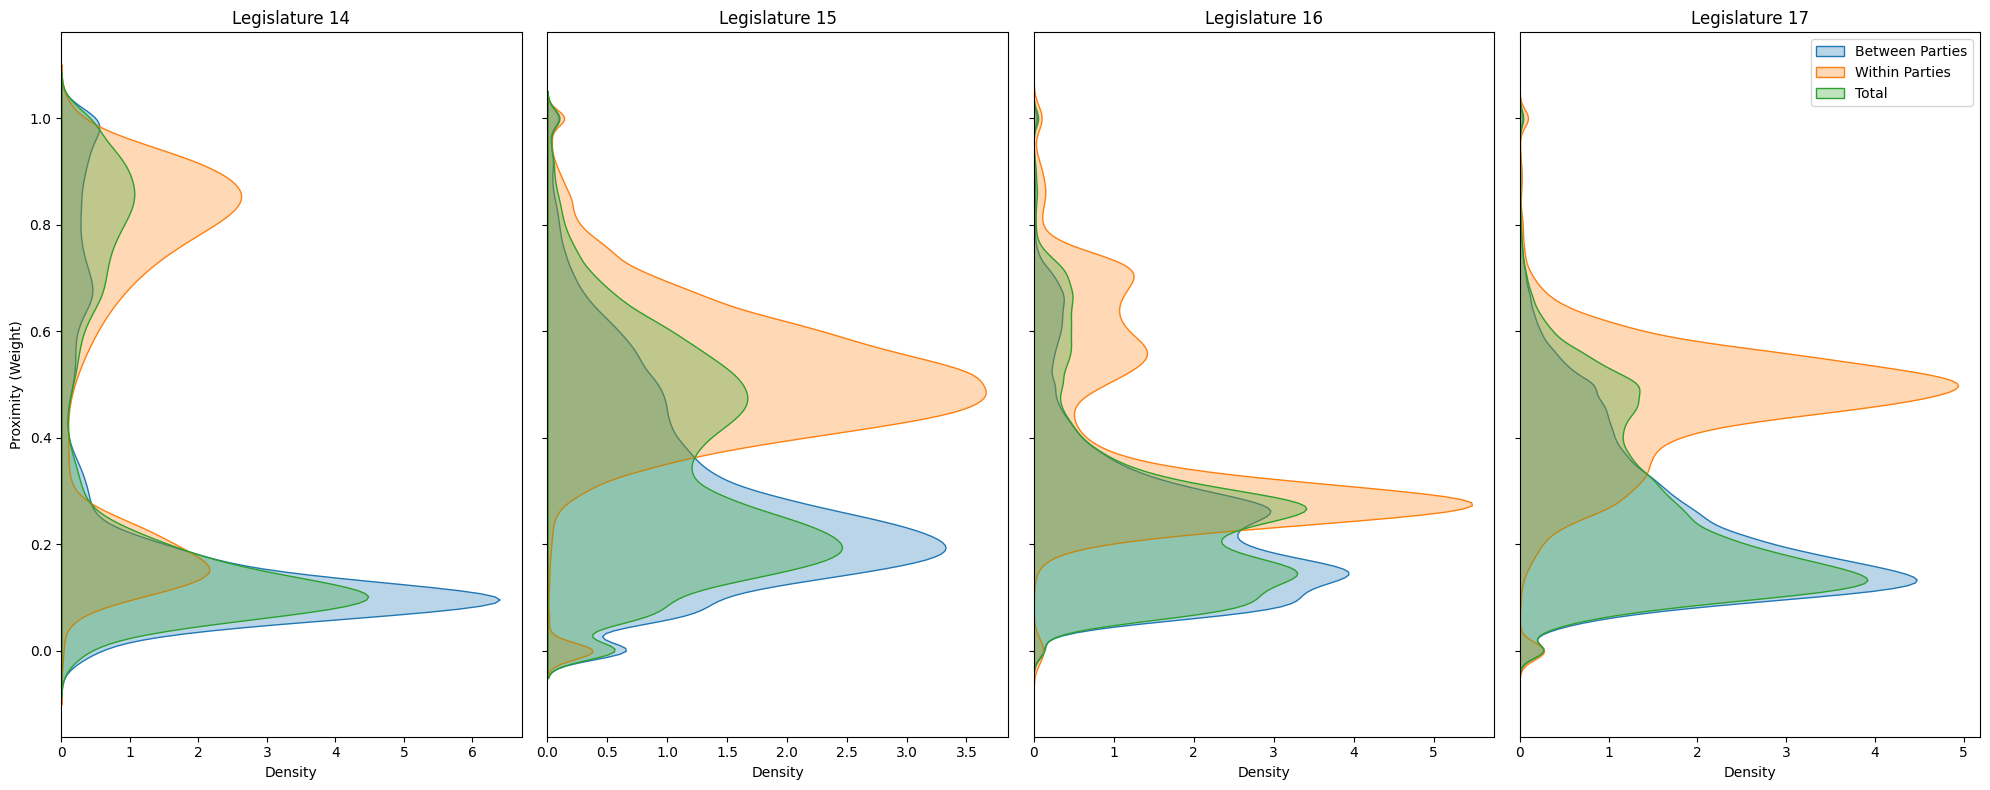

In [ ]:
data_for_vertical_plot = [
    (14, proximites_without_parties_14, proximites_debuties_14, proximites_within_parties_14),
    (15, proximites_without_parties_15, proximites_debuties_15, proximites_within_parties_15),
    (16, proximites_without_parties_16, proximites_debuties_16, proximites_within_parties_16),
    (17, proximites_without_parties_17, proximites_debuties_17, proximites_within_parties_17)
]
plot_proximity_comparison_vertical_all(data_for_vertical_plot)

While the previous plot showed global trends, this step visualizes the **Density Distribution of Voting Proximities** for each specific legislature individually.
* **`plot_proximity_comparison`** is called for each term (17th, 16th, 15th, 14th).
* These plots provide a granular view, allowing us to inspect the cohesion levels of individual political parties and their specific positioning relative to the rest of the assembly.

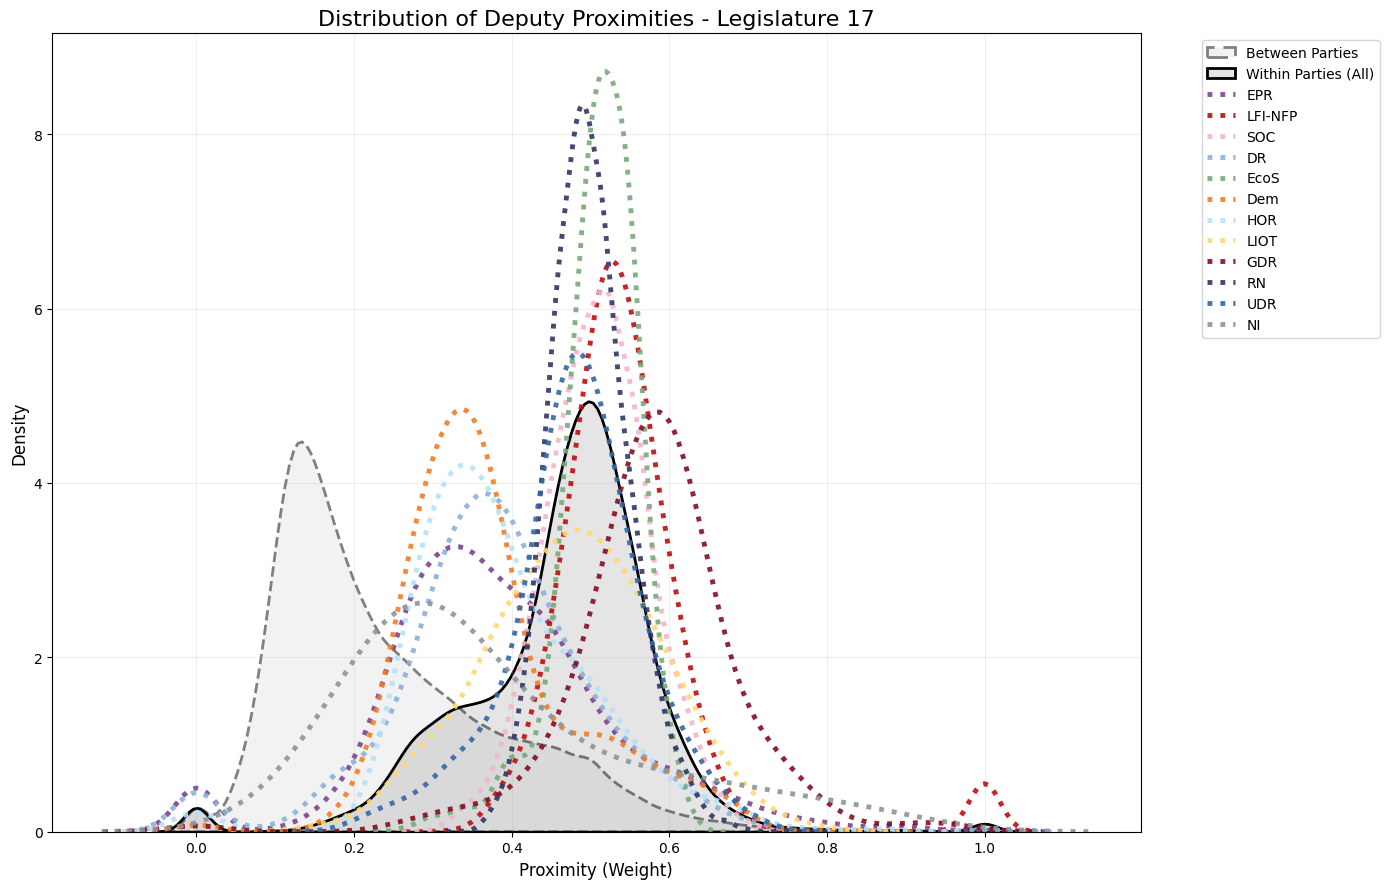

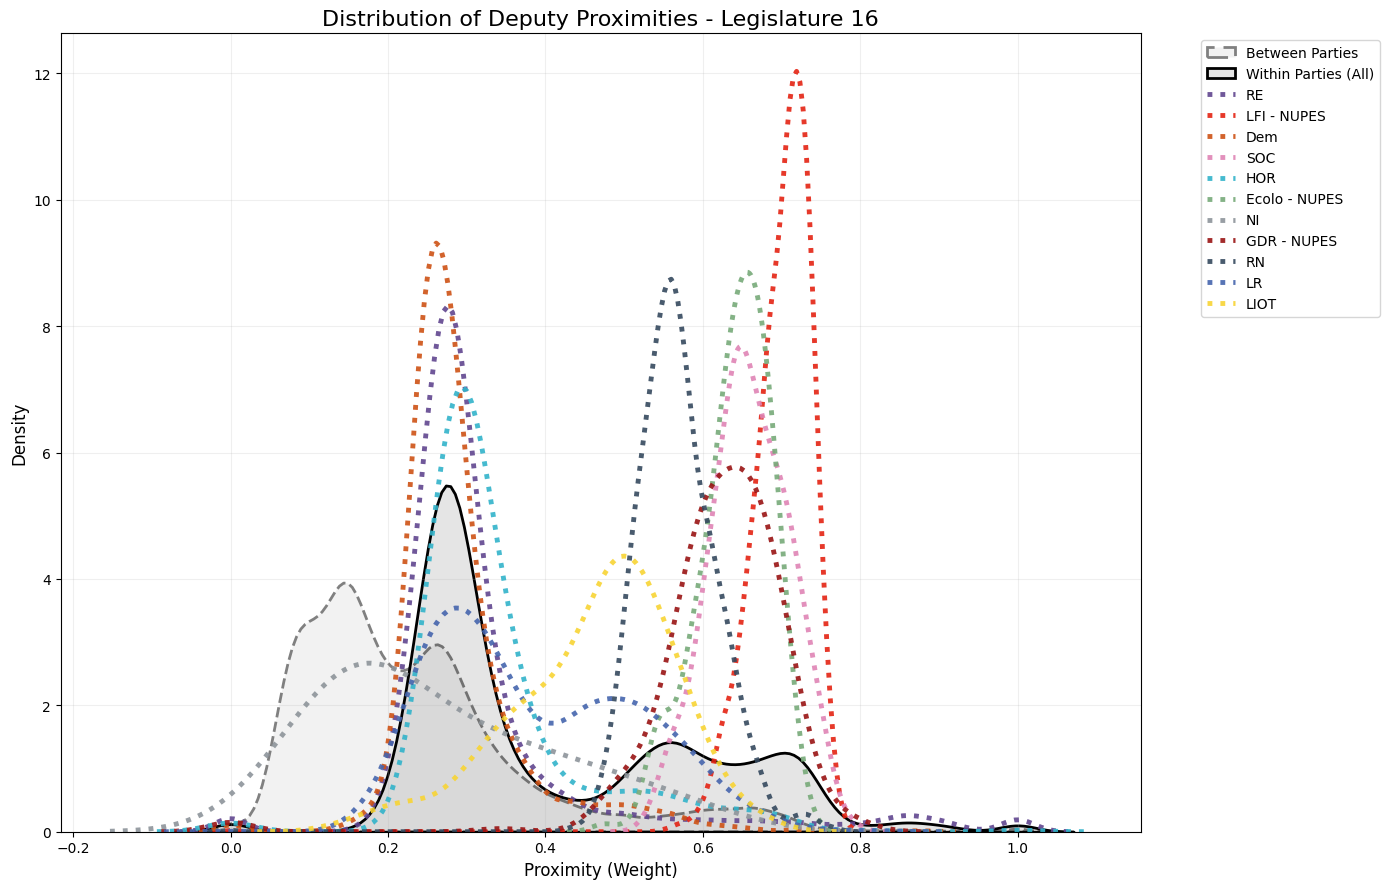

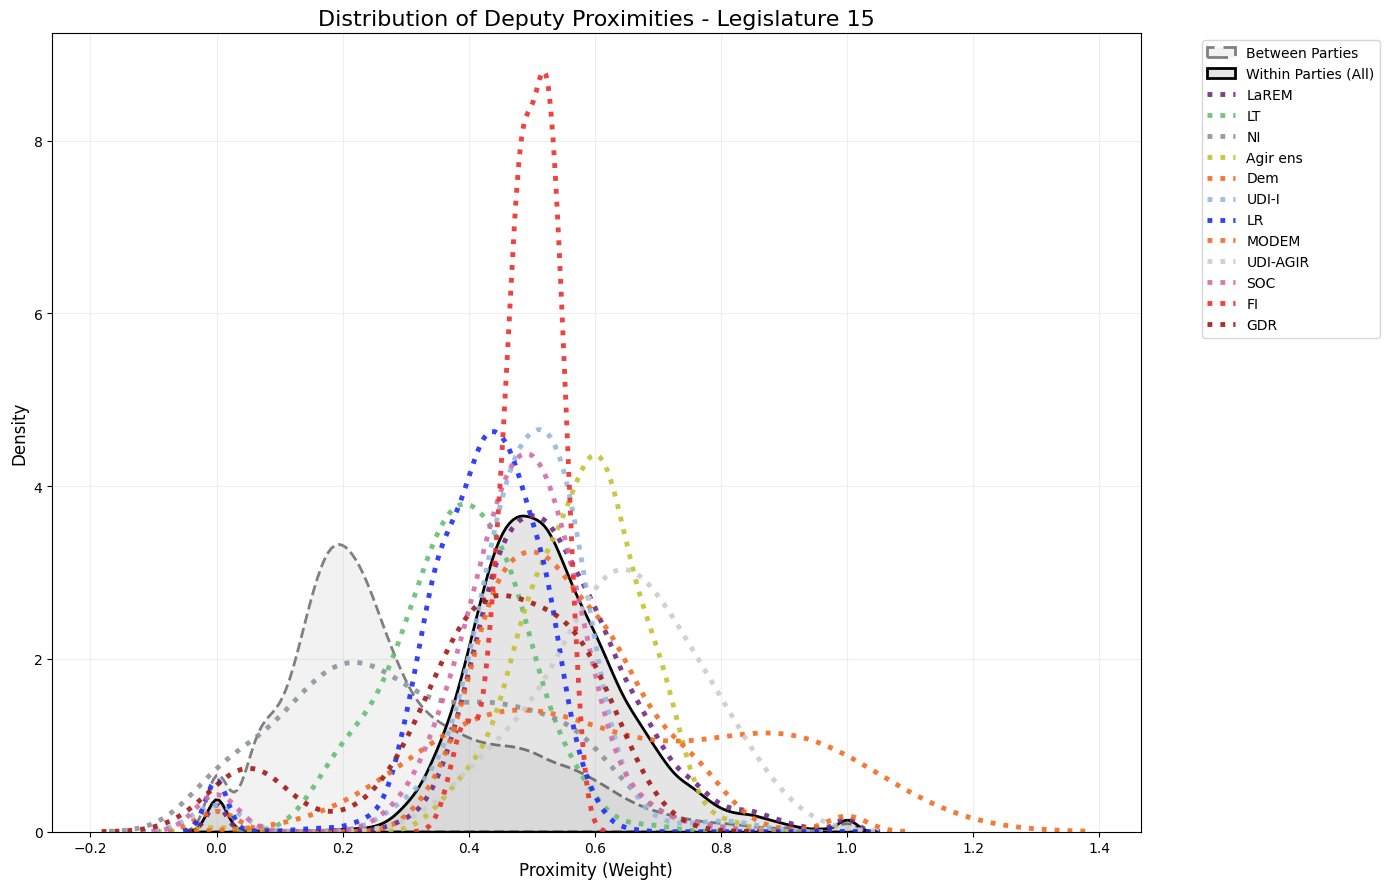

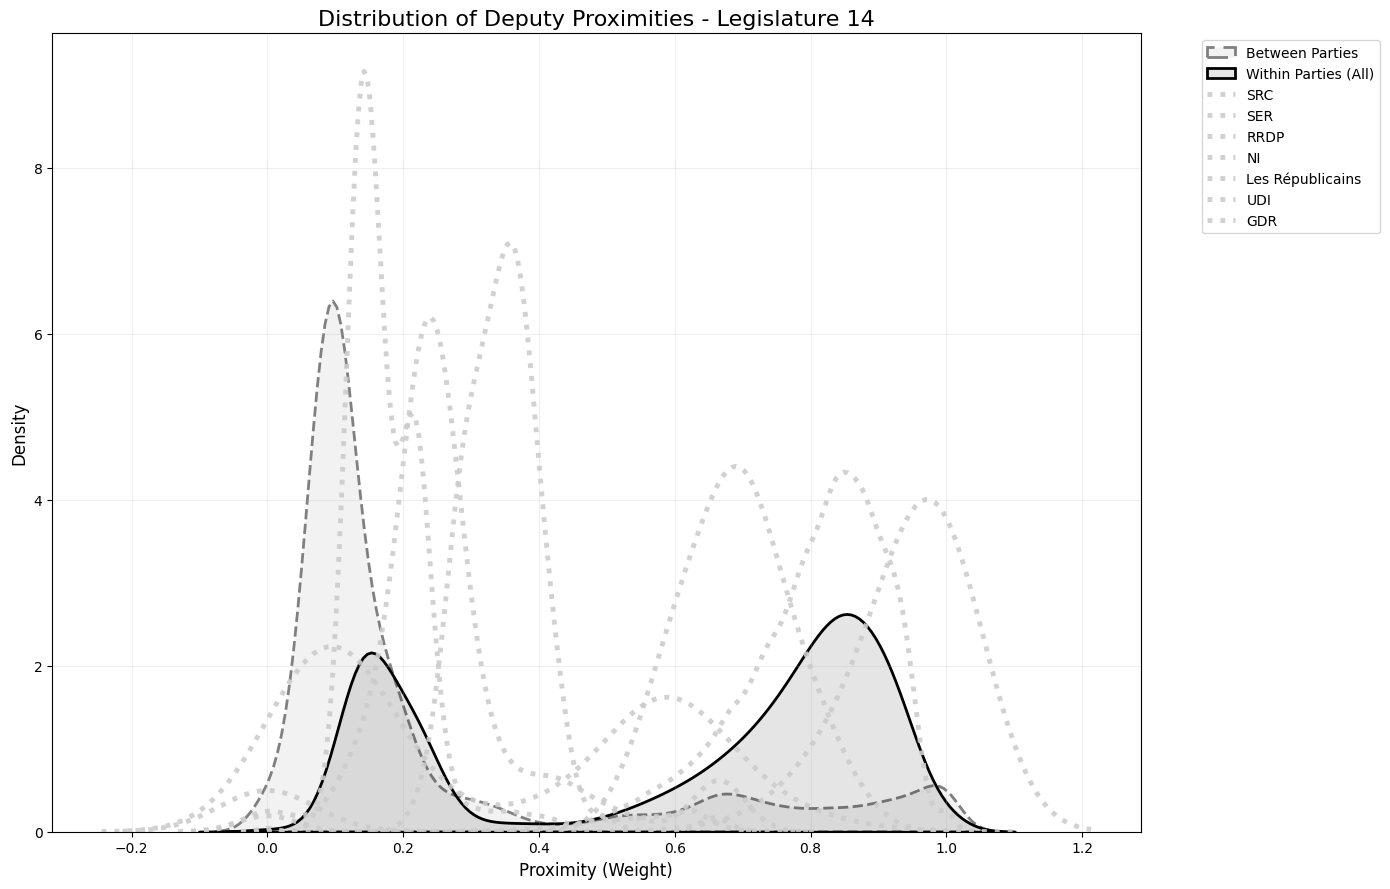

In [ ]:
plot_proximity_comparison(proximites_without_parties_17, proximites_debuties_17, proximites_within_parties_17, proximites_of_parties_17, legislature_17["deputies"], 17)
plot_proximity_comparison(proximites_without_parties_16, proximites_debuties_16, proximites_within_parties_16, proximites_of_parties_16, legislature_16["deputies"], 16)
plot_proximity_comparison(proximites_without_parties_15, proximites_debuties_15, proximites_within_parties_15, proximites_of_parties_15, legislature_15["deputies"], 15)
plot_proximity_comparison(proximites_without_parties_14, proximites_debuties_14, proximites_within_parties_14, proximites_of_parties_14, legislature_14["deputies"], 14)

This cell plots the **Distribution of Weighted Degrees** across the four legislatures.
* **Weighted Degree**: This metric represents the cumulative strength of agreement a deputy has with all other colleagues. It serves as a proxy for consensus.
* **`plot_degree_distribution_vertical_all`**: Displays histograms of these degrees side-by-side. This visualization highlights structural shifts in the assembly, such as the transition from a bimodal distribution (two distinct voting blocks) in earlier terms to a more unimodal or shifted distribution in recent years.

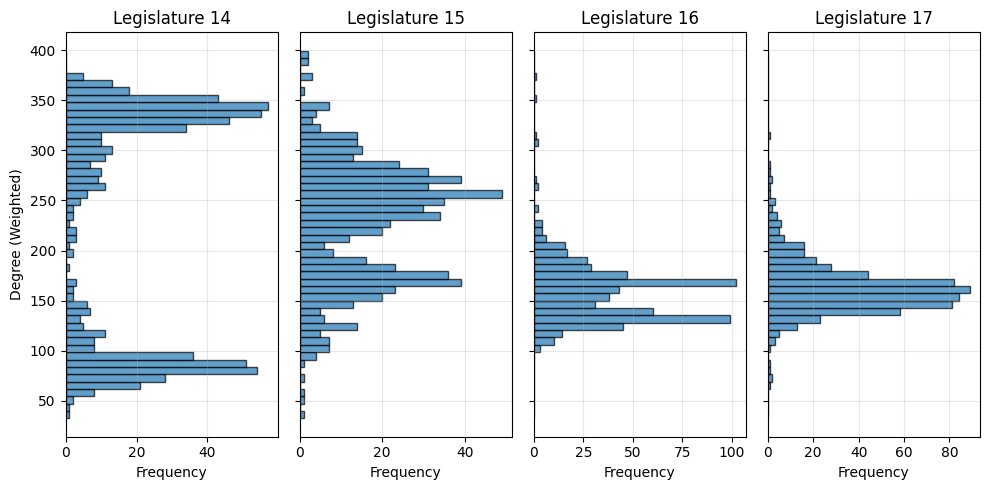

In [ ]:
graphs_for_dist = [(14, G_14), (15, G_15), (16, G_16), (17, G_17)]
plot_degree_distribution_vertical_all(graphs_for_dist)

# Community analysis

For each legislature, the Louvain communities are processed and analyzed. Details of the functions used are provided in the corresponding `Util` section.

What we can see for each legislature :

- **Community plot** : each nodes are colored according to the political party. Zones represent the different Louvain communities. (The name of the community (i.e. 0, 1 or 2) is arbitrary and does not represent any continuity across legislatures.)


- **Community matrix** : the matrix represents the proportion of a party across the processed communities.

- **Graph and Proximity matrix within and between communities** : the average pourcentage of common vote is processed within and between communities to analyse proximities and cohesion.



## 14'th Legislature

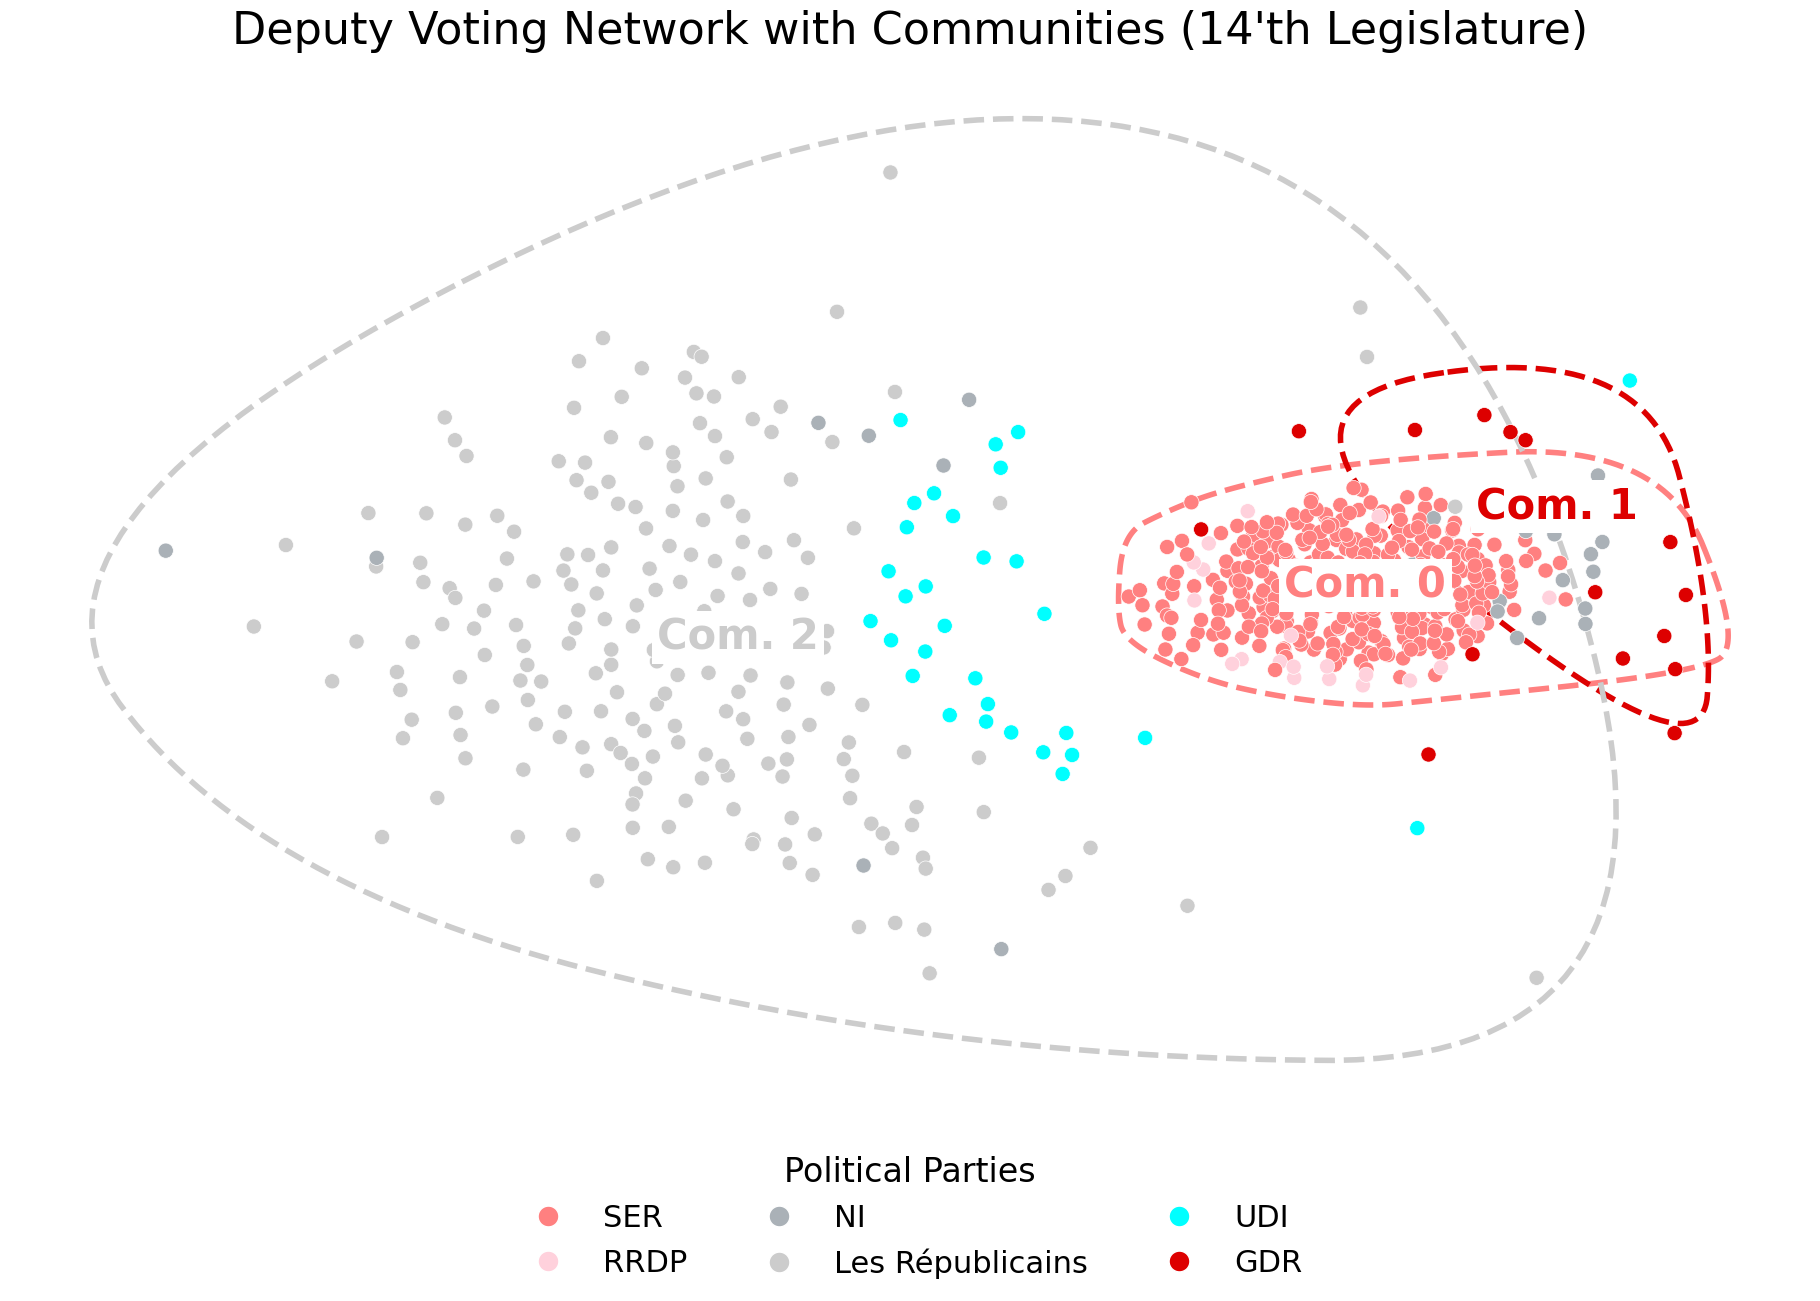

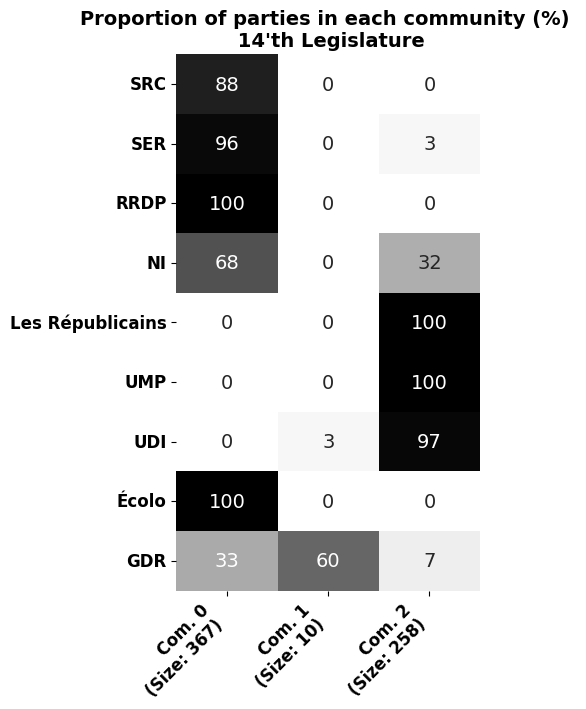

/tmp/ipython-input-2249532233.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(communities_members))


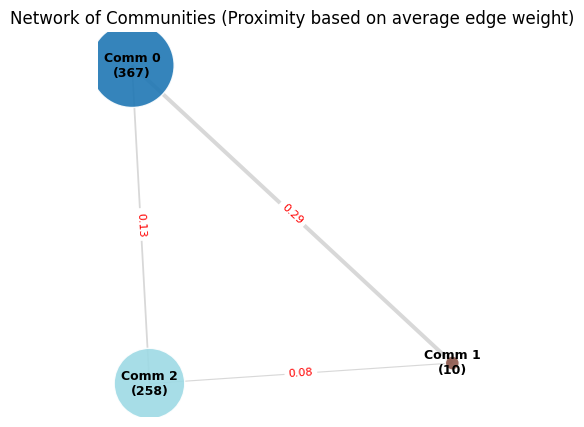

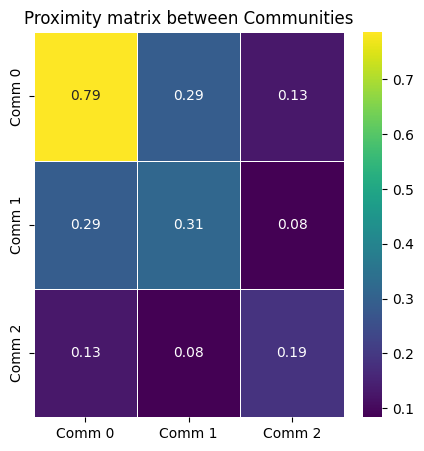

In [ ]:
communities_set, modularity_score = plot_network_with_communities(G_14,legislature_14["deputies"], 14)
organ_name_dict, partis_members = get_party_info(legislature_14["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_14["deputies"].keys()), 14)
analyze_community_proximity(G_14, communities_set, legislature_14["deputies"], plot=True)

## 15'th Legislature

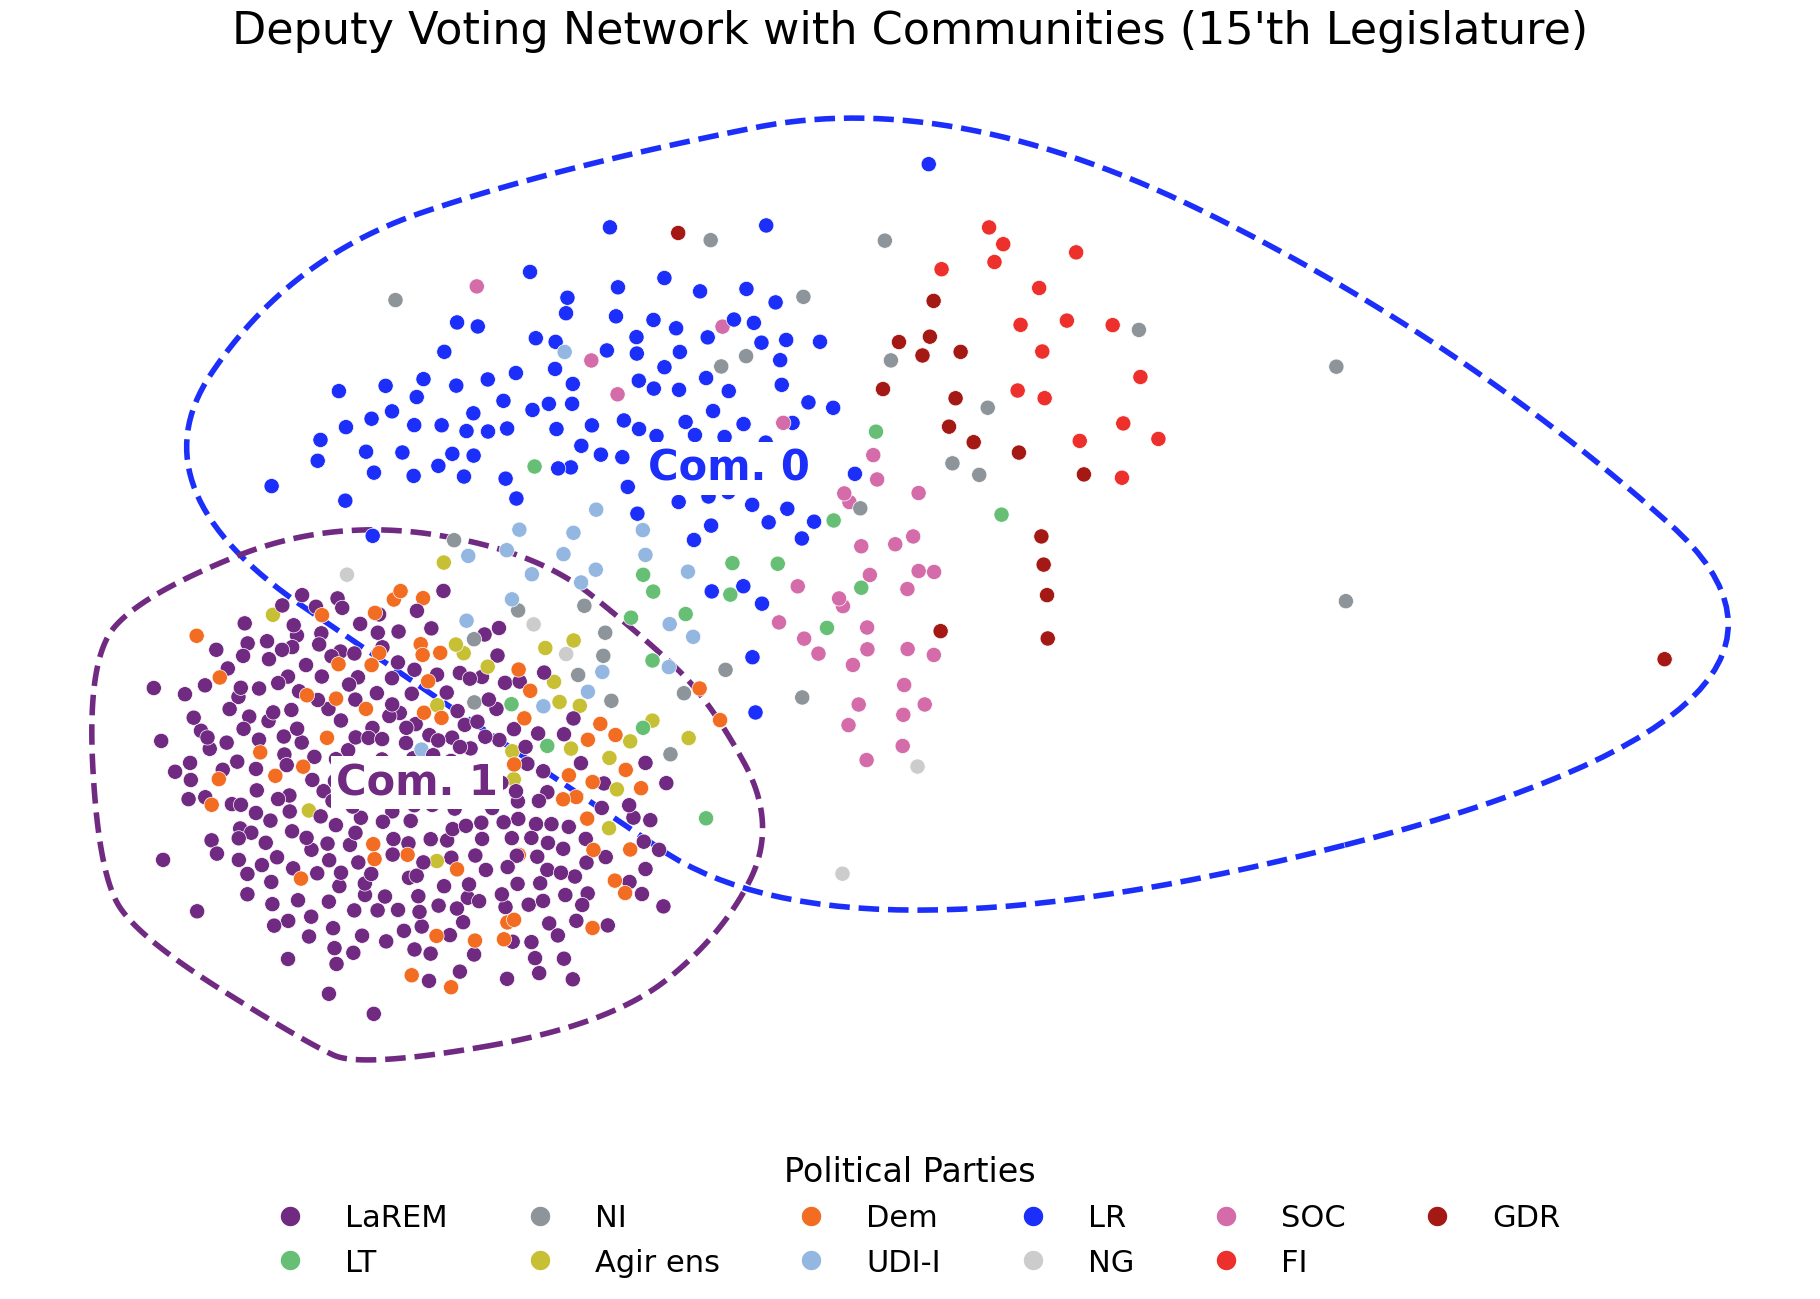

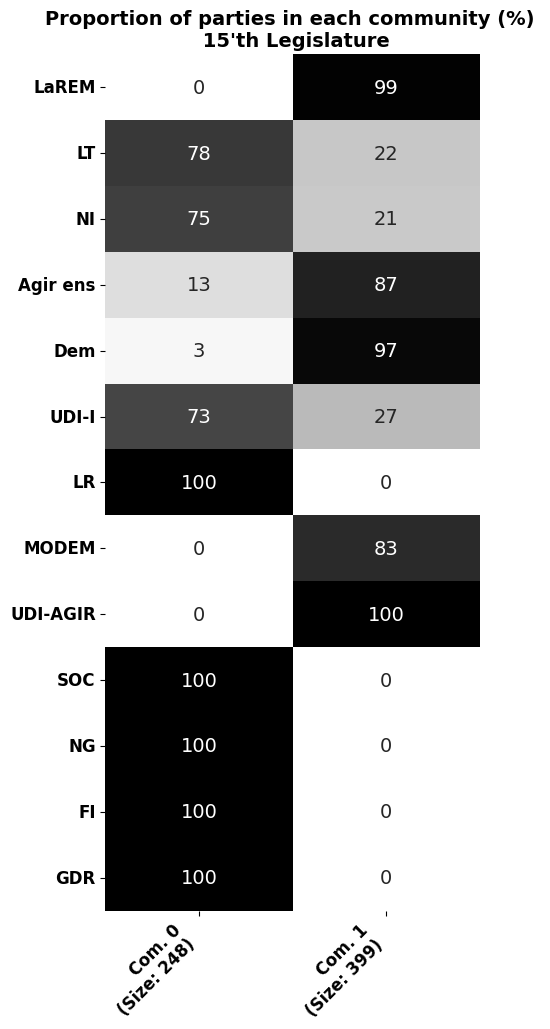

/tmp/ipython-input-2249532233.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(communities_members))


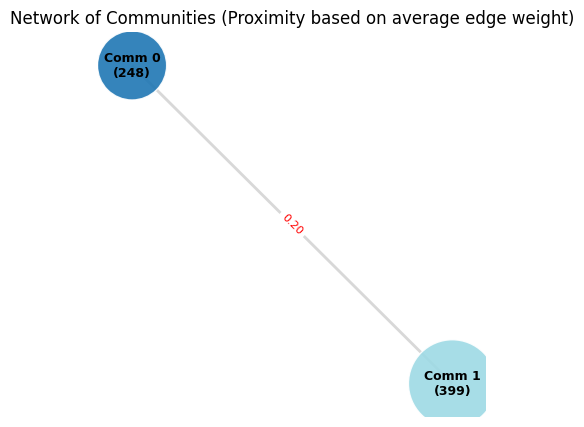

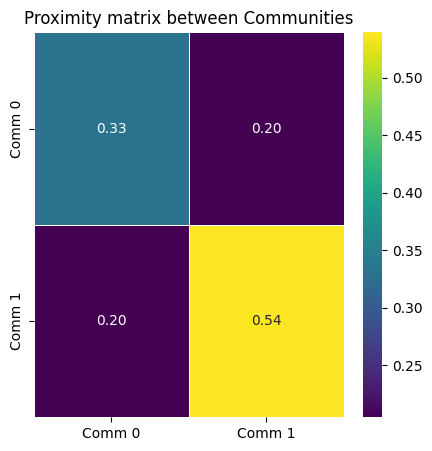

In [ ]:
communities_set, modularity_score = plot_network_with_communities(G_15,legislature_15["deputies"], 15)
organ_name_dict, partis_members = get_party_info(legislature_15["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_15["deputies"].keys()), 15)
analyze_community_proximity(G_15, communities_set, legislature_15["deputies"], plot=True)

## 16'th Legislature

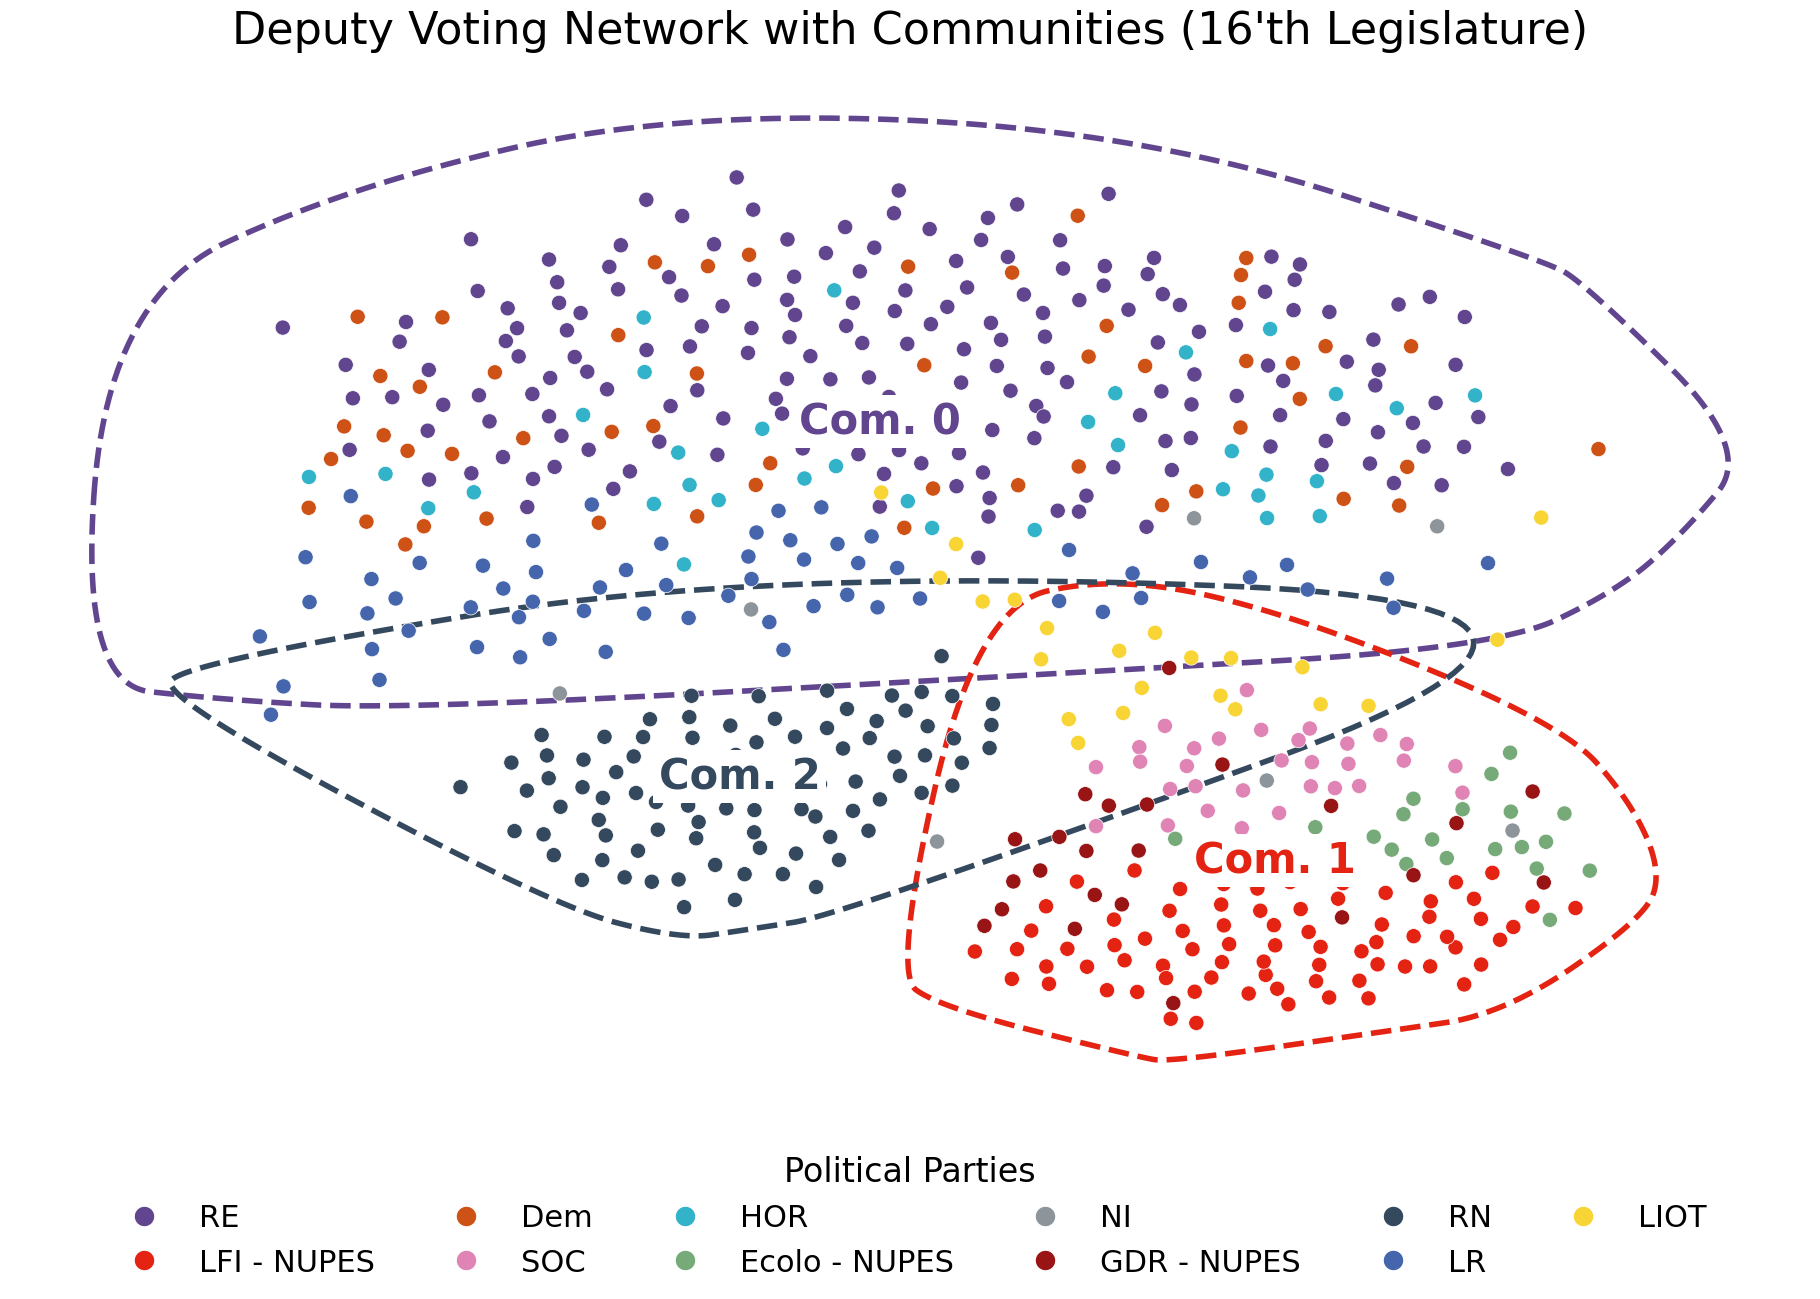

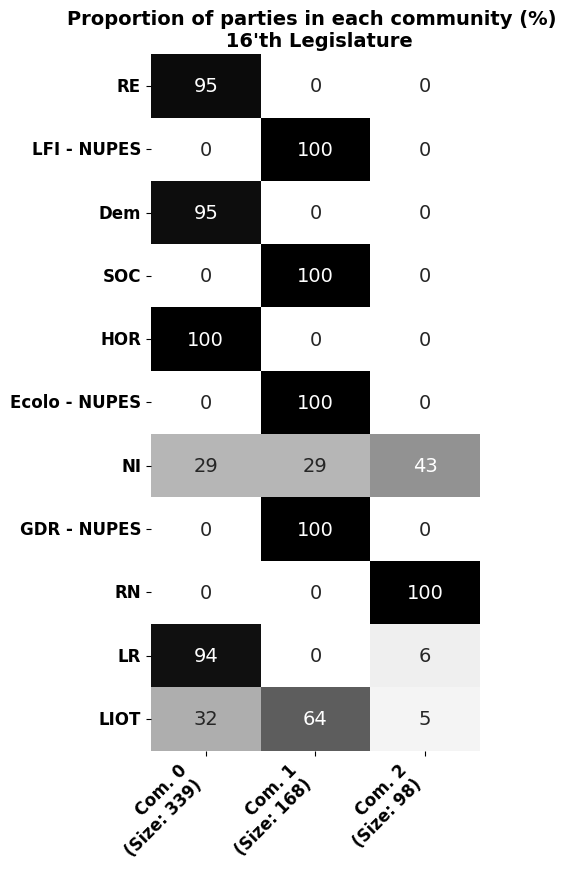

/tmp/ipython-input-2249532233.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(communities_members))


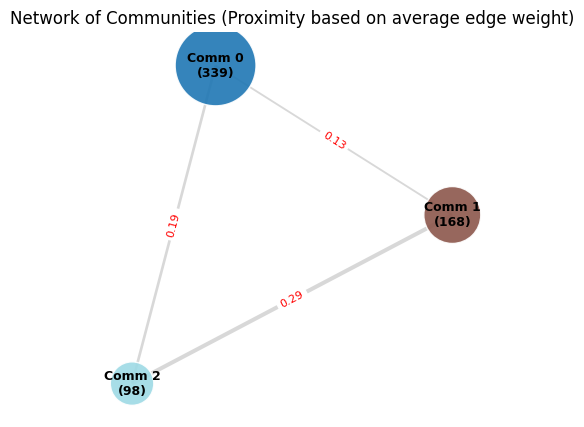

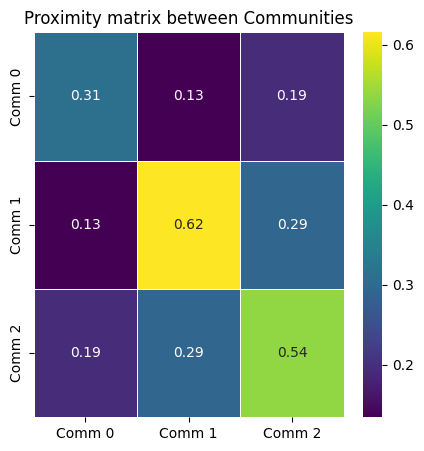

In [ ]:
communities_set, modularity_score = plot_network_with_communities(G_16,legislature_16["deputies"], 16)
organ_name_dict, partis_members = get_party_info(legislature_16["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_16["deputies"].keys()), 16)
analyze_community_proximity(G_16, communities_set, legislature_16["deputies"], plot=True)

## 17'th Legislature

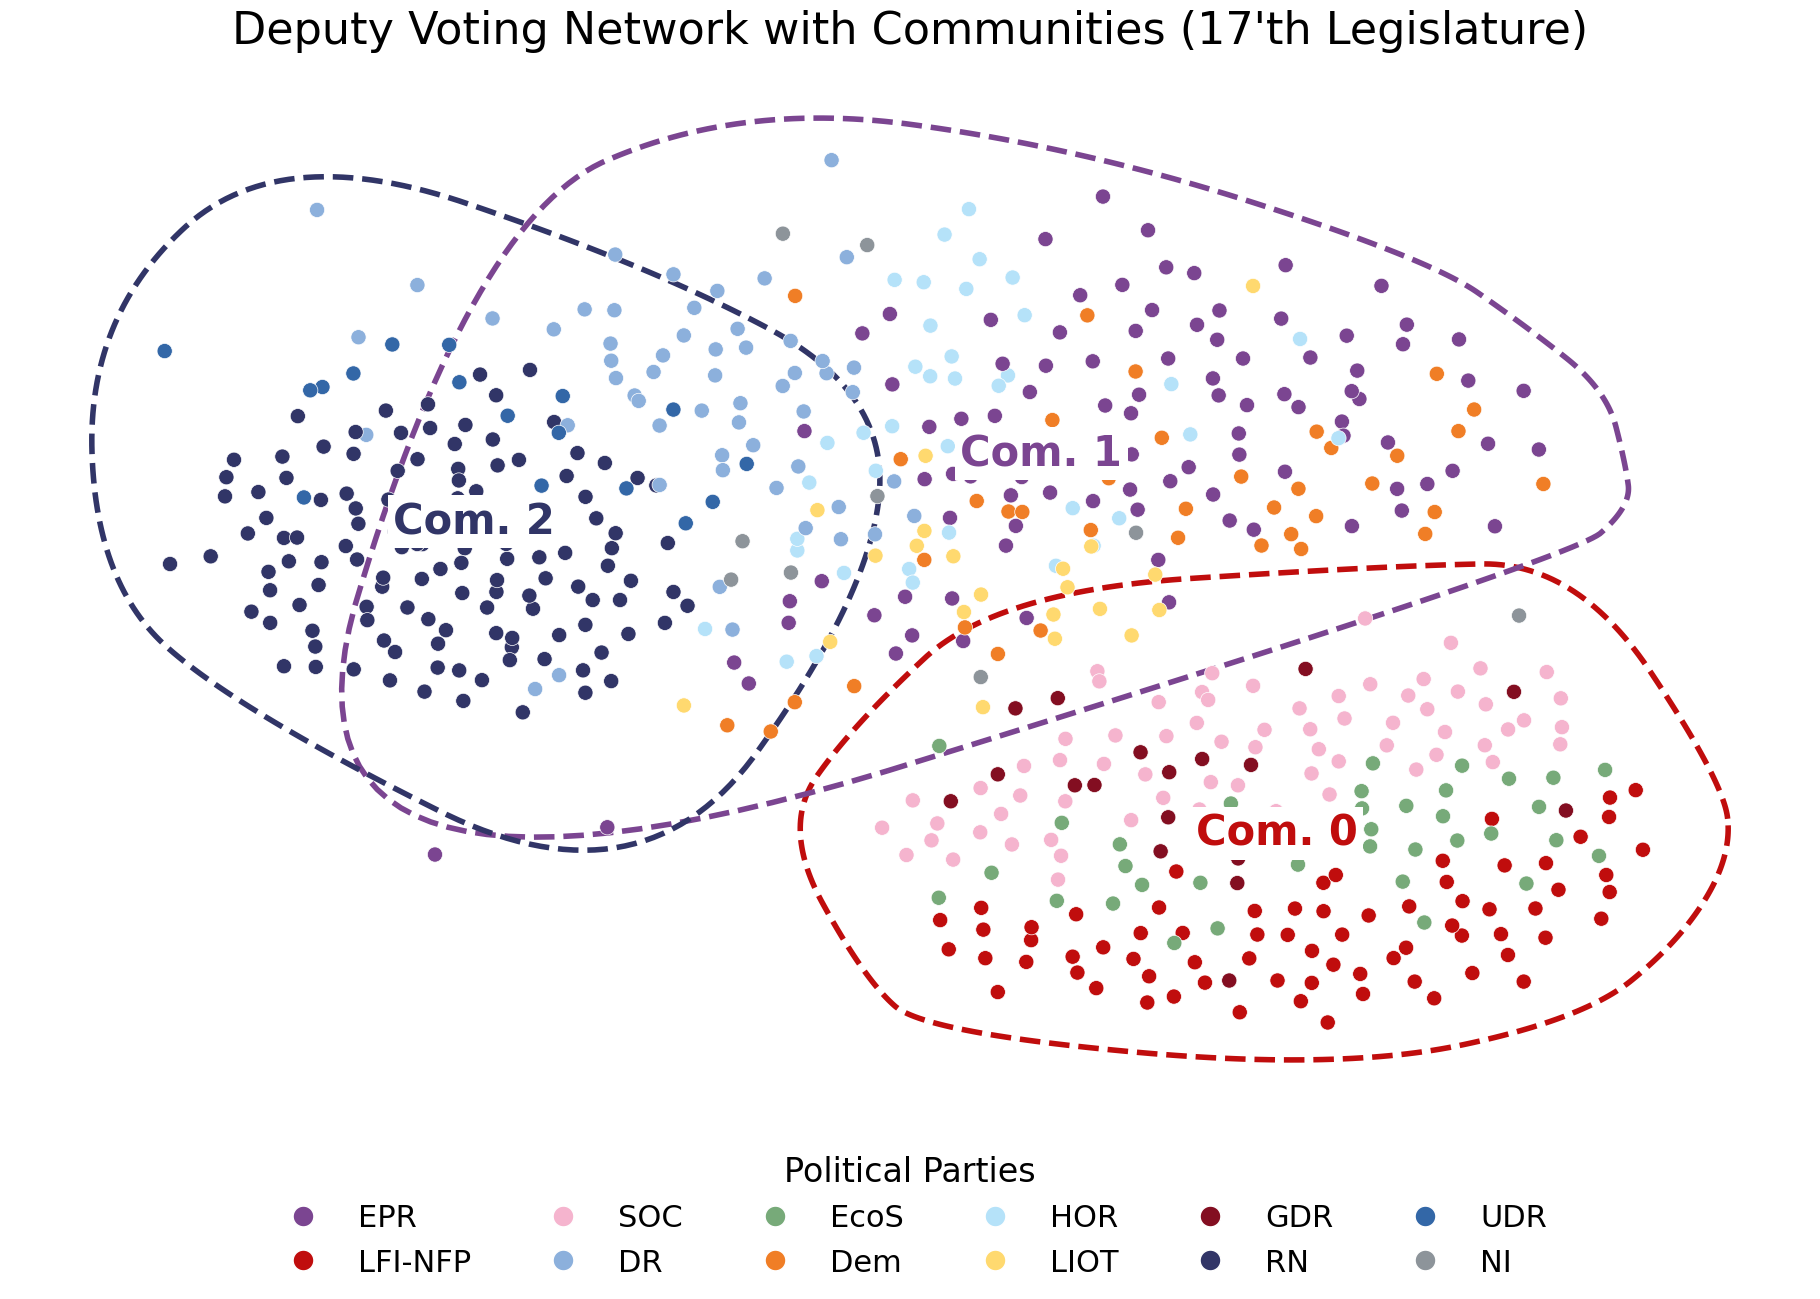

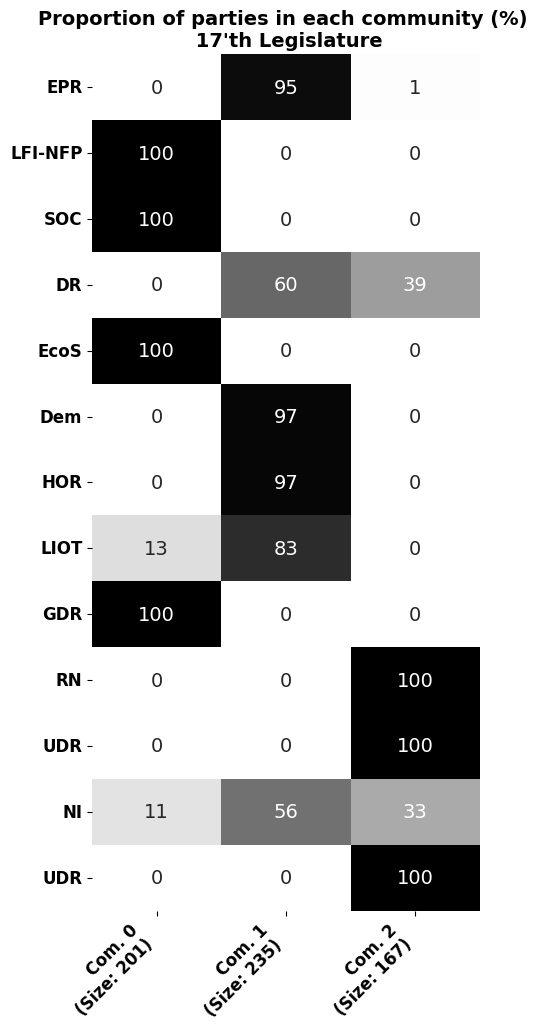

/tmp/ipython-input-2249532233.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(communities_members))


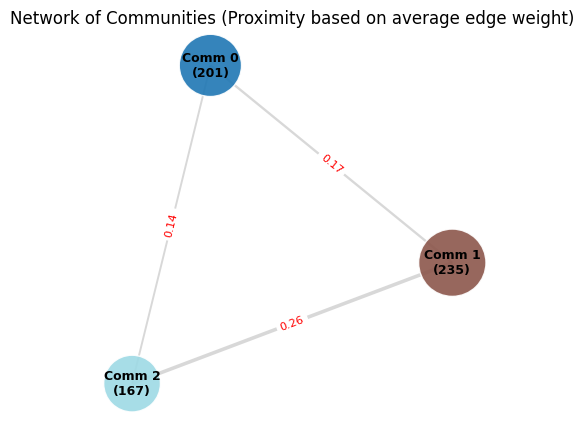

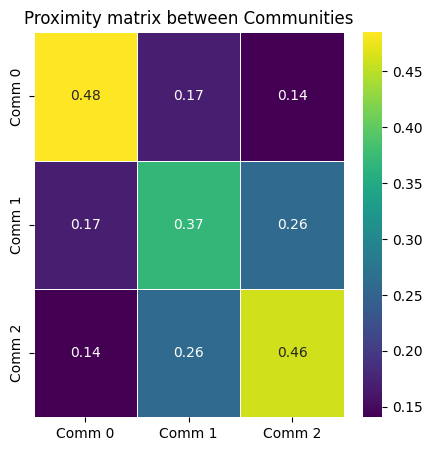

In [ ]:
communities_set, modularity_score = plot_network_with_communities(G_17,legislature_17["deputies"], 17)
organ_name_dict, partis_members = get_party_info(legislature_17["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_17["deputies"].keys()), 17)
analyze_community_proximity(G_17, communities_set, legislature_17["deputies"], plot=True)

# Natural Language Processing (NLP)

> To complete, a written analysis
of the last legislature is proposed using the previous calcu-
lated Louvain communities.

> This textual examination is
made over every recorded parliamentary act of speaking during the 17th legislature
and aims to observe the polarization of the speeches, and
assess the fracture suggested between the different parties.

> This work is based on the previous communities captured by the Louvain method. We retrieve the representatives from the 17th legislature as well as their speeches and the communities processed using the Louvain method.




In [ ]:
# --- STEP 0: Gathering of every required pieces ---
data = legislature_17['deputies']

communities_adress = gistlinks['communities'][17]
communities = requests.get(communities_adress)
communities.raise_for_status()
communities = communities.json()


Secondly, all deputy acts of speech are processed and tokenised to retain only the alpha elements. A counter is also created for each community.
When then compute the Term Frequency for each word:
\begin{equation}
tf(t, c) = K + (1 - K) \cdot \frac{f_{t,c}}{\max_{\{t' \in c\}} f_{t',c}}
\end{equation}

In [ ]:

# --- STEP 1: Pre-processing speeches for each deputy ---
# We create a set of unique words for each deputy to easily check for word presence for Basic and advanced processing
print('Preprocessing speeches')
stop_words = set(stopwords.words('french'))
community_counters = {}
deputy_words = {}
all_words = set()
for i,community in enumerate(communities):
    print(f"Community {i} : {len(community)} deputees")
    community_counter = Counter()
    for j,deputee_id in enumerate(community):
        print(f"  Processing deputee {j+1}/{len(community)}: {deputee_id}",end='\r')
        deputy_words[deputee_id] = Counter()
        for phrase in data[deputee_id]['speeches']:
            token = word_tokenize(phrase, language='french')
            processed_words = [word.lower() for word in token if word.isalpha() and word.lower() not in stop_words]
            community_counter.update(processed_words)
            all_words.update(processed_words)
            deputy_words[deputee_id].update(processed_words)
    community_counters[i] = community_counter
    print('\n')


# --- STEP 2: Calculating Term Frequency (TF) ---
# It is a basic overall word frequency.
print('Calculate Term Frequency')
doc_tfs = {}
all_words = set()
num_communities = len(community_counters)
def TF(count, max_count):
    if max_count == 0:
        return 0
    K =0.25
    return K + (1-K) * count / max_count

for comm_name, counter in community_counters.items():
    max_words_in_doc = max(counter.values())

    augmented_tfs_for_doc = {}
    if max_words_in_doc > 0:
        for word, count in counter.items():
            augmented_tfs_for_doc[word] = TF(count,max_words_in_doc)
    doc_tfs[comm_name] = augmented_tfs_for_doc

    # Update list of words
    for word in counter.keys():
        all_words.add(word)



Preprocessing speeches
Community 0 : 235 deputees
  Processing deputee 235/235: PA721984

Community 1 : 201 deputees
  Processing deputee 201/201: PA795808

Community 2 : 167 deputees




Then, we compute respectively the community term frequency, inverse document frequency with the following methods:

\begin{equation}
idf(t, C) = \log\left(\frac{N}{n_t + 1}\right)
\end{equation}

\begin{equation}
cdf(t, c) = \frac{n_{t,c}}{N_c}
\end{equation}


The community term frequency and the term frequency holds different significance and are both important for the final result. The first one computes wether or not a word is shared among members of a community, the second one holds a basic overall frequency usage.


Finally the multiplication of the 3 terms to obtain the modified score:

\begin{equation}
S(t, c) = tf(t, c) \cdot idf(t, C) \cdot cdf(t, c)
\end{equation}


In [ ]:


# --- STEP 3: Calculate Community Term Frequency (DF) within each community ---
# This measure if a word is shared among members of a community
# It is 1 if every members used this word and close to 0 if this word has been used by only a few hand of members.
def CTF(word,N):
    word_appearance = ctf_number_sharing_inside_communities[i].get(word, 0)
    return word_appearance / N

print('Calculate DF inside communities')
ctf_inside_communities = {}
ctf_number_sharing_inside_communities = {}
for i, community in enumerate(communities):
    ctf_inside = Counter()
    print(f"Processing Community {i} for DF calculation...")
    for deputee_id in community:
            ctf_inside.update(deputy_words[deputee_id].keys())
    ctf_number_sharing_inside_communities[i] = ctf_inside

for i,ctf_inside in ctf_number_sharing_inside_communities.items():
    number_deputies = len(communities[i])
    ctf_inside = ctf_inside.copy()
    for word in ctf_inside.keys():
        ctf_inside[word] = CTF(word,number_deputies)
    ctf_inside_communities[i] = ctf_inside


# --- STEP 4: Calculate Inverse Document Frequency (IDF) across communities ---
# This measures how unique a word is across all communities.
def IDF(word,N):
    word_appearance = all_words_frequency.get(word, num_communities)
    return math.log( N / (word_appearance + 1))

print('Calculate IDF across all documents')
all_words_frequency = Counter()
for comm_name, counter in community_counters.items():
    print(f"Processing Community {comm_name} for IDF calculation...")
    # Calculate document frequency for each word
    all_words_frequency.update(counter.keys())

community_idf_scores = {}
for word in all_words_frequency:
    community_idf_scores[word] = IDF(word,num_communities)

# --- STEP 5: Calculate the final Community DF-IDF score ---
# The final score is the product between the term frequency in a community, the intra-community DF and the inter-community IDF.
print('Final Calculation')
community_ctf_idf_scores = {}
for i in range(num_communities):
    community_ctf_idf_scores[i] = {}
    for word in all_words:
        term_freq = doc_tfs[i].get(word,0)
        idf = community_idf_scores.get(word, 0)
        ctf_inside_community = ctf_inside_communities[i].get(word,0)
        # We use the raw document frequency as the 'term frequency' component
        community_ctf_idf_scores[i][word] = term_freq * idf * ctf_inside_community

Calculate DF inside communities
Processing Community 0 for DF calculation...
Processing Community 1 for DF calculation...
Processing Community 2 for DF calculation...
Calculate IDF across all documents
Processing Community 0 for IDF calculation...
Processing Community 1 for IDF calculation...
Processing Community 2 for IDF calculation...
Final Calculation



Visualizing Community DF-IDF scores...
Displaying plot...


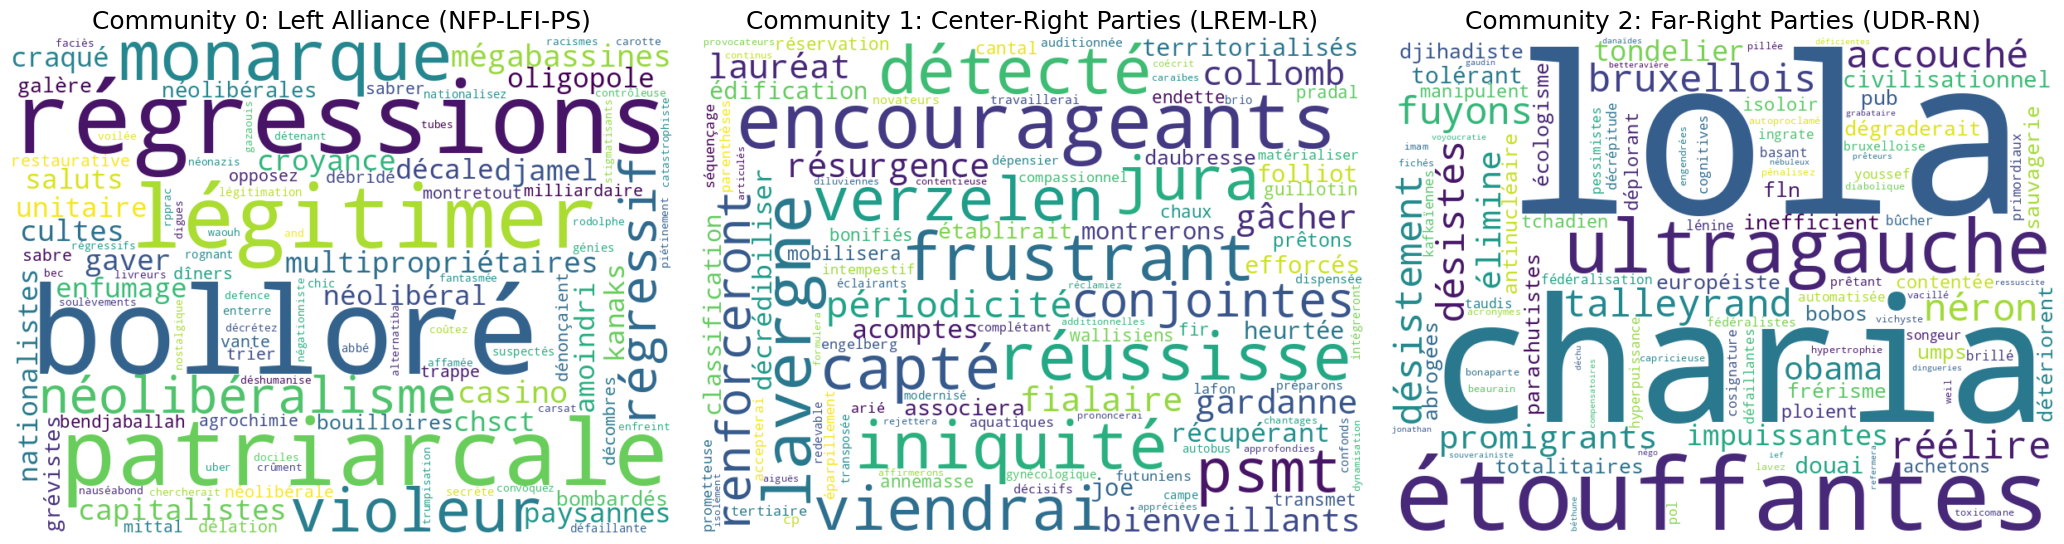

In [ ]:
# --- STEP 6: Visualize the results using the provided plotting function ---
print("\nVisualizing Community DF-IDF scores...")
community_ctf_idf_scores_bis = {}
community_ctf_idf_scores_bis['Community 0: Left Alliance (NFP-LFI-PS)'] = community_ctf_idf_scores[1]
community_ctf_idf_scores_bis['Community 1: Center-Right Parties (LREM-LR)'] = community_ctf_idf_scores[0]
community_ctf_idf_scores_bis['Community 2: Far-Right Parties (UDR-RN)'] = community_ctf_idf_scores[2]
plot_community_wordclouds(community_ctf_idf_scores_bis)


The final wordcloud is effectively better compared to one obtained with a basic tf-idf. The improvement here is a couting of wether or not a word his shared in a community. A description of this result is provided in the report.